In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, chi2, f_classif, RFE, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

import joblib  




import warnings
warnings.filterwarnings('ignore')




In [2]:
df = pd.read_csv('Final_merged_data.csv')

In [3]:
df.head()

,Country,Year,CO2 emission (Tons),Population(2022),Area(Square kilometre),proportion of global land area,Density(Square kilometre),Access to electricity (% of population),Access to clean fuels for cooking,Electricity from fossil fuels (TWh),...,Primary energy consumption per capita (kWh/person),Renewables (% equivalent primary energy),gdp_growth,gdp_per_capita,Latitude,Longitude,Exchange_Rate,CO2_per_capita,Energy_per_CO2,Renewable_ratio
0,Argentina,2000,4.979455e+09,45510318.0,2780400.0,0.018,16,95.783290,95.00,50.37,...,18849.810,12.283858,-0.788999,7708.099115,-38.416097,-63.616672,0.999500,109.413755,172.280076,0.364497
1,Argentina,2001,5.113459e+09,45510318.0,2780400.0,0.018,16,95.511060,95.60,42.91,...,18210.120,15.937488,-4.408840,7208.373114,-38.416097,-63.616672,0.999500,112.358229,162.071975,0.463290
2,Argentina,2002,5.237851e+09,45510318.0,2780400.0,0.018,16,96.228870,96.10,39.70,...,17275.256,16.249306,-10.894485,2593.404563,-38.416097,-63.616672,3.063257,115.091507,150.100181,0.475977
3,Argentina,2003,5.372482e+09,45510318.0,2780400.0,0.018,16,96.442635,96.45,46.73,...,18326.521,14.408259,8.837041,3349.806300,-38.416097,-63.616672,2.900629,118.049759,155.244036,0.423869
4,Argentina,2004,5.529525e+09,45510318.0,2780400.0,0.018,16,96.653500,97.20,57.35,...,19261.457,12.185576,9.029573,4277.721573,-38.416097,-63.616672,2.923301,121.500479,158.529885,0.351098


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 22 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Country                                             357 non-null    object 
 1   Year                                                357 non-null    int64  
 2   CO2 emission (Tons)                                 357 non-null    float64
 3   Population(2022)                                    357 non-null    float64
 4   Area(Square kilometre)                              357 non-null    float64
 5   proportion of global land area                      357 non-null    float64
 6   Density(Square kilometre)                           357 non-null    int64  
 7   Access to electricity (% of population)             357 non-null    float64
 8   Access to clean fuels for cooking                   357 non-null    float64
 9  

## Create new Features

In [5]:
def create_new_features(df):
    """
    Create new features for climate and energy data analysis.
    This function creates features that provide unique information while avoiding redundancy.
    
    """
    # Create a copy to avoid modifying the original DataFrame
    df_new = df.copy()
    

    # Higher values indicate more carbon-intensive economies
    df_new['CO2_per_GDP'] = df_new['CO2 emission (Tons)'] / (df_new['gdp_per_capita'] * df_new['Population(2022)'])
    
    
    # Higher values indicate more economic value generated per unit of energy
    df_new['GDP_per_energy'] = df_new['gdp_per_capita'] / df_new['Primary energy consumption per capita (kWh/person)']
    
    # Higher values indicate higher emission density
    df_new['CO2_per_area'] = df_new['CO2 emission (Tons)'] / df_new['Area(Square kilometre)']

    # Real Purchasing Power GDP
    # This feature converts GDP per capita to a more comparable measure across countries by adjusting for exchange rates
    # When a country's currency is stronger (higher exchange rate), its real purchasing power may be lower internationally
    # Lower values indicate potentially higher purchasing power in global terms
    # This helps compare living standards between countries more accurately than nominal GDP figures
    df_new['Real_Purchasing_Power_GDP'] = df_new['gdp_per_capita'] / df_new['Exchange_Rate']
    

    # Exchange Rate Volatility
    # Calculate the standard deviation of exchange rates over a 3-year rolling window for each country
    # Higher values indicate greater currency instability and unpredictability
    # The groupby ensures we only compare exchange rates within the same country over time
    # The window=3 parameter means we're looking at 3 consecutive years of data
    df_new['Exchange_Rate_Volatility'] = df_new.groupby('Country')['Exchange_Rate'].transform(lambda x: x.rolling(window=3).std())

    # Economic External Sensitivity
    # Combines exchange rate volatility with economic size (GDP per capita)
    # Measures how vulnerable an economy might be to external currency shocks
    # Higher values indicate larger economies with unstable currencies, which may face significant international trade disruptions
    # Lower values indicate either stable currencies or smaller economies less exposed to global markets
    df_new['Economic_External_Sensitivity'] = df_new['Exchange_Rate_Volatility'] * df_new['gdp_per_capita']



    # Exchange-Rate Adjusted GDP Growth
    # Subtracts the percentage change in exchange rate from GDP growth rate
    # Isolates "real" economic growth by removing the effect of currency fluctuations
    # If a currency depreciates (negative pct_change), this adjustment increases the growth figure
    # If a currency appreciates (positive pct_change), this adjustment decreases the growth figure
    # Helps distinguish between actual productivity improvements and growth that appears due to currency effects
    df_new['Exchange_Adjusted_GDP_Growth'] = df_new['gdp_growth'] - df_new.groupby('Country')['Exchange_Rate'].pct_change()

    
    # Time-based features (calculated with appropriate time series handling)
    # Note: These require data across multiple years per country
    
    # CO2_growth_rate: Year-over-year change in emissions
    # Positive values indicate increasing emissions, negative values indicate decreasing emissions
    df_new['CO2_growth_rate'] = df_new.groupby('Country')['CO2 emission (Tons)'].pct_change()
    
    # GDP_growth_per_capita: Year-over-year change in GDP per capita
    # Indicator of economic development pace
    df_new['GDP_growth_per_capita'] = df_new.groupby('Country')['gdp_per_capita'].pct_change()
    
    # CO2_trend: Normalized emission change since first year in dataset
    # Shows how emissions have changed relative to baseline
    def calculate_trend(group):
        if len(group) > 1:
            first_value = group.iloc[0]
            if first_value != 0:
                return (group - first_value) / first_value
            else:
                return group - first_value
        return 0
    
    df_new['CO2_trend'] = df_new.groupby('Country')['CO2 emission (Tons)'].transform(calculate_trend)
    
    # Renewable_adoption_rate: Year-over-year change in renewable energy adoption
    # Positive values indicate accelerating renewable adoption
    df_new['Renewable_adoption_rate'] = df_new.groupby('Country')['Renewables (% equivalent primary energy)'].pct_change()


    # Fill missing values with first non-missing value for each country
    # Get list of columns with missing values
    columns_with_missing = df_new.columns[df_new.isna().any()].tolist()
    
    # For each country, fill missing values with first non-missing value in each column
    for country in df_new['Country'].unique():
        # Get data for this country only
        country_mask = df_new['Country'] == country
        country_data = df_new.loc[country_mask].sort_values('Year')
        
        # For each column with missing values
        for col in columns_with_missing:
            # Find first non-missing value for this country and column
            first_valid = country_data.loc[~country_data[col].isna(), col]
            
            if not first_valid.empty:
                first_value = first_valid.iloc[0]
                
                # Fill missing values for this country and column with the first valid value
                country_missing_mask = country_mask & df_new[col].isna()
                df_new.loc[country_missing_mask, col] = first_value

    

    
    return df_new

In [6]:
new_df = create_new_features(df)

In [7]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 33 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Country                                             357 non-null    object 
 1   Year                                                357 non-null    int64  
 2   CO2 emission (Tons)                                 357 non-null    float64
 3   Population(2022)                                    357 non-null    float64
 4   Area(Square kilometre)                              357 non-null    float64
 5   proportion of global land area                      357 non-null    float64
 6   Density(Square kilometre)                           357 non-null    int64  
 7   Access to electricity (% of population)             357 non-null    float64
 8   Access to clean fuels for cooking                   357 non-null    float64
 9  

In [8]:
new_df.isnull().sum()

Country                                               0
Year                                                  0
CO2 emission (Tons)                                   0
Population(2022)                                      0
Area(Square kilometre)                                0
proportion of global land area                        0
Density(Square kilometre)                             0
Access to electricity (% of population)               0
Access to clean fuels for cooking                     0
Electricity from fossil fuels (TWh)                   0
Electricity from renewables (TWh)                     0
Low-carbon electricity (% electricity)                0
Primary energy consumption per capita (kWh/person)    0
Renewables (% equivalent primary energy)              0
gdp_growth                                            0
gdp_per_capita                                        0
Latitude                                              0
Longitude                                       

## Predict per capita carbon dioxide emissions (CO2_per_capita)

Target variable: CO2_per_capita
Number of features: 25
NaN values in features: 0
NaN values in target: 0
Dataset shape after removing NaN targets: (357, 33)
Imputation completed. Dataset is now clean.
Train set: 267 samples, Test set: 90 samples


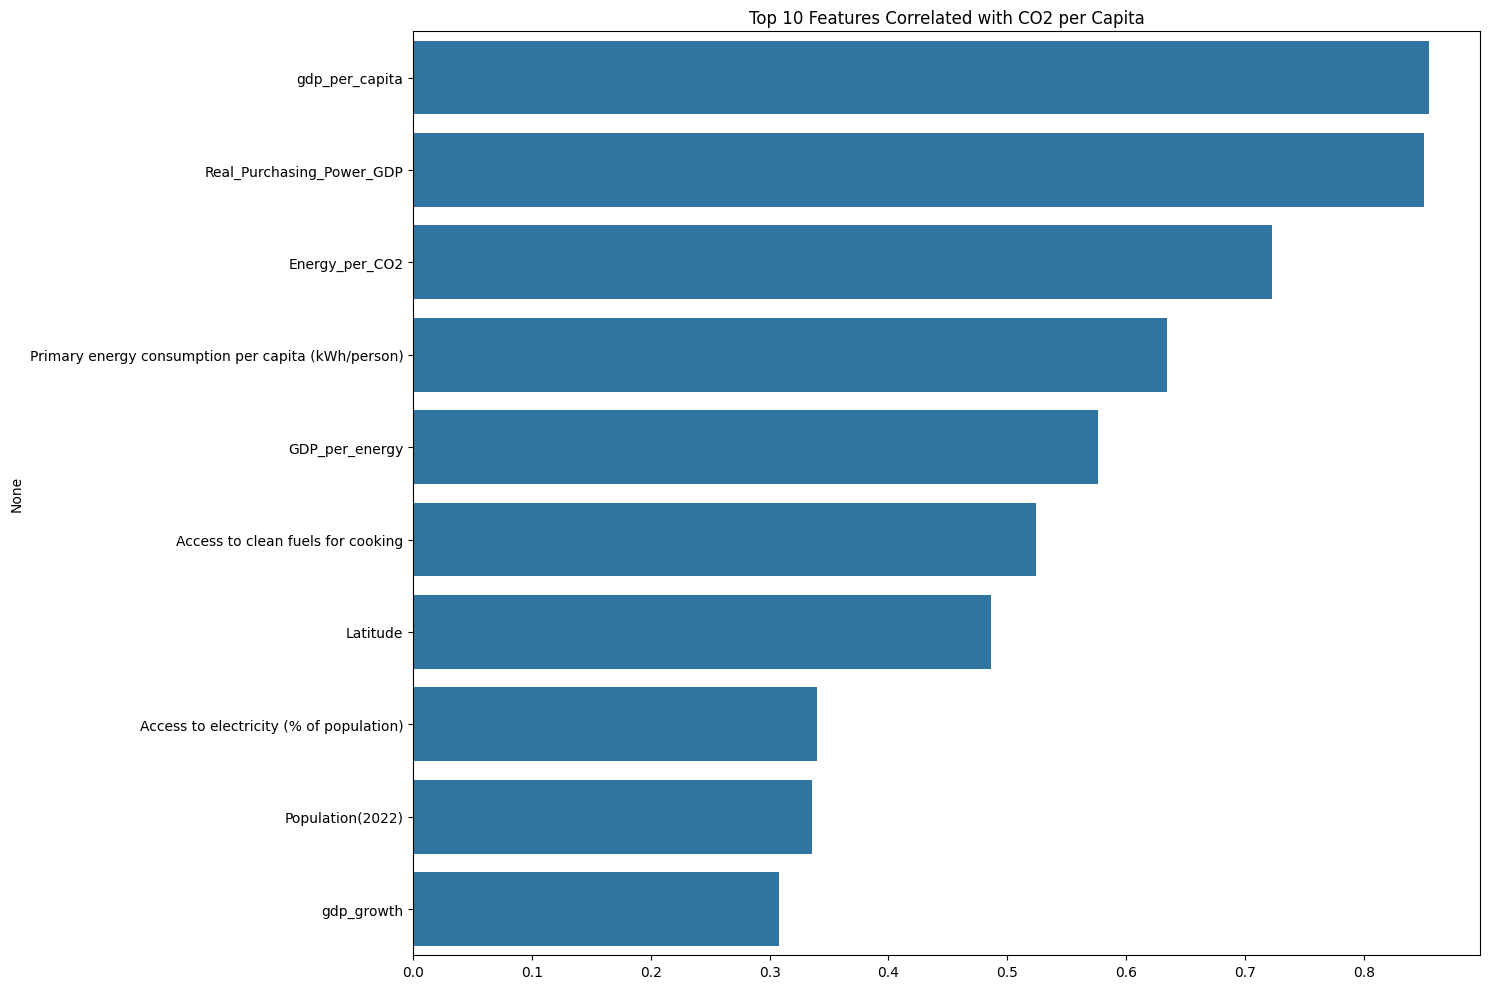


Top 10 selected features:
1. Real_Purchasing_Power_GDP: 757.88
2. gdp_per_capita: 739.00
3. Energy_per_CO2: 305.81
4. Primary energy consumption per capita (kWh/person): 171.28
5. GDP_per_energy: 142.32
6. Access to clean fuels for cooking: 100.76
7. Latitude: 78.39
8. Population(2022): 34.94
9. Access to electricity (% of population): 34.31
10. gdp_growth: 28.14

PCA reduced dimensions from 25 to 12 components
Variance explained: 0.9560

Training with selected features and 5-fold cross-validation:
Linear Regression    CV RMSE: 134.1485, Test RMSE: 146.1105, Test R²: 0.8428
Error training Ridge Regression with selected features: solve() got an unexpected keyword argument 'sym_pos'
Lasso Regression     CV RMSE: 134.1459, Test RMSE: 146.1013, Test R²: 0.8428
ElasticNet           CV RMSE: 133.7524, Test RMSE: 145.6563, Test R²: 0.8438
Random Forest        CV RMSE: 59.7599, Test RMSE: 64.8589, Test R²: 0.9690
Gradient Boosting    CV RMSE: 39.5776, Test RMSE: 29.5247, Test R²: 0.9936
SVR  

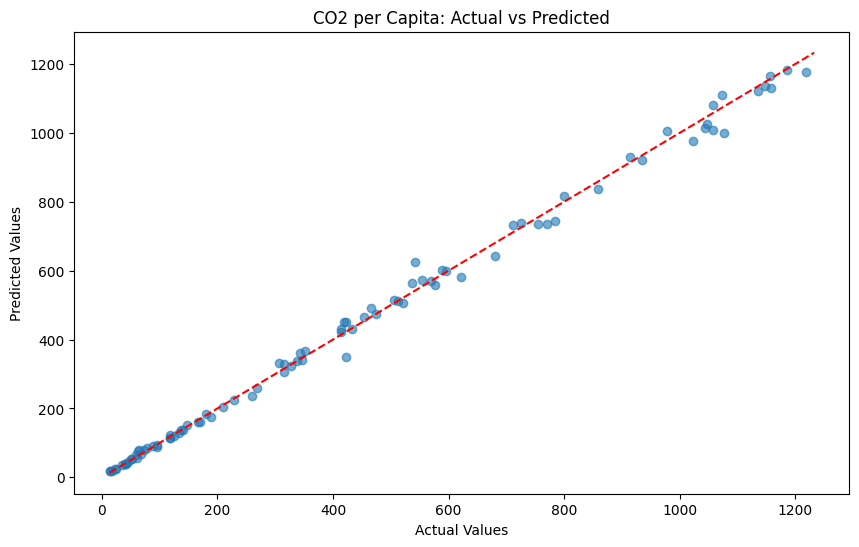

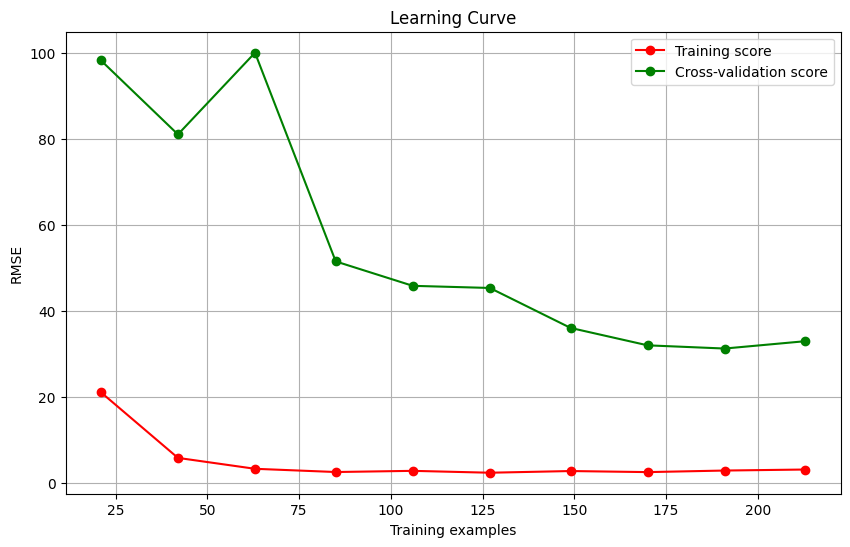


CO2 per Capita prediction analysis completed.


In [9]:
# ============================================
# CO2 per Capita Prediction Implementation
# ============================================

# Define target and features
target_column = 'CO2_per_capita'
exclude_columns = ['Country', 'Year', 'CO2_per_capita', 'CO2 emission (Tons)', 
                   'CO2_per_GDP', 'CO2_per_area', 'CO2_growth_rate', 'CO2_trend']

# Filter columns that exist in the DataFrame
exclude_columns = [col for col in exclude_columns if col in new_df.columns]
features = [col for col in new_df.columns if col not in exclude_columns]

print(f"Target variable: {target_column}")
print(f"Number of features: {len(features)}")

# Check for NaN values
print(f"NaN values in features: {new_df[features].isna().sum().sum()}")
print(f"NaN values in target: {new_df[target_column].isna().sum()}")

# Remove rows where target is NaN
new_df = new_df.dropna(subset=[target_column])
print(f"Dataset shape after removing NaN targets: {new_df.shape}")

# Create X and y
X = new_df[features]
y = new_df[target_column]

# Check for infinite values and replace them with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Create an imputer to handle NaN values
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
print("Imputation completed. Dataset is now clean.")

# Split dataset - using a larger test set to better evaluate generalization
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.25, random_state=42)
print(f"Train set: {X_train.shape[0]} samples, Test set: {X_test.shape[0]} samples")

# Correlation Analysis
plt.figure(figsize=(15, 10))
correlation = new_df[features + [target_column]].corr()[target_column].sort_values(ascending=False)
top_correlated = correlation.drop(target_column).abs().sort_values(ascending=False).head(10)
sns.barplot(x=top_correlated.values, y=top_correlated.index)
plt.title('Top 10 Features Correlated with CO2 per Capita')
plt.tight_layout()
plt.show()


# ============================================
# MODEL TRAINING WITH DIRECT FEATURE SETS
# ============================================

# Keep the same number of features throughout to prevent mismatch
if len(features) > 10:
    # Feature Selection with SelectKBest - but keeping it fixed at 10 features
    k = 10
    selector = SelectKBest(f_regression, k=k)
    selector.fit(X_train, y_train)

    feature_scores = pd.DataFrame({
        'Feature': X_train.columns,
        'Score': selector.scores_
    }).sort_values('Score', ascending=False)

    selected_features = feature_scores.head(k)['Feature'].tolist()
    print(f"\nTop {k} selected features:")
    for i, feature in enumerate(selected_features, 1):
        print(f"{i}. {feature}: {feature_scores[feature_scores['Feature'] == feature]['Score'].values[0]:.2f}")
    
    # Use the selected features for all subsequent operations
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
else:
    # If we have fewer than 10 features, use all of them
    selected_features = features
    X_train_selected = X_train
    X_test_selected = X_test
    print(f"\nUsing all {len(features)} features since there are fewer than 10 available")

# Using PCA for dimensionality reduction
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95)  # Keeping 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"\nPCA reduced dimensions from {X_train.shape[1]} to {X_train_pca.shape[1]} components")
print(f"Variance explained: {sum(pca.explained_variance_ratio_):.4f}")

# ============================================
# MODEL TRAINING WITH CROSS-VALIDATION
# ============================================

# Define models with regularization to prevent overfitting
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.01),
    'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5),
    'Random Forest': RandomForestRegressor(
        n_estimators=100, 
        max_depth=5,  # Reduced depth
        min_samples_leaf=5,  # Increased min samples
        max_features='sqrt',
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=100, 
        max_depth=3,  # Reduced depth
        min_samples_leaf=5,  # Increased min samples
        learning_rate=0.05,  # Reduced learning rate
        random_state=42
    ),
    'SVR': SVR(kernel='rbf', C=1.0)
}

# Set up cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Results dictionary
results = {}

# Training with selected features
print("\nTraining with selected features and 5-fold cross-validation:")
for name, model in models.items():
    try:
        # Create pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        
        # Cross-validation
        cv_scores = cross_val_score(pipeline, X_train_selected, y_train, 
                                   cv=cv, scoring='neg_mean_squared_error')
        cv_rmse = np.sqrt(-cv_scores.mean())
        
        # Train model
        pipeline.fit(X_train_selected, y_train)
        
        # Evaluate on test set
        y_pred = pipeline.predict(X_test_selected)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        test_mae = mean_absolute_error(y_test, y_pred)
        test_r2 = r2_score(y_test, y_pred)
        
        # Store results
        results[f"{name} (Selected)"] = {
            'CV RMSE': cv_rmse,
            'Test RMSE': test_rmse, 
            'Test MAE': test_mae, 
            'Test R²': test_r2,
            'Model': pipeline,
            'Uses PCA': False
        }
        
        print(f"{name:20} CV RMSE: {cv_rmse:.4f}, Test RMSE: {test_rmse:.4f}, Test R²: {test_r2:.4f}")
    except Exception as e:
        print(f"Error training {name} with selected features: {e}")

# Training with PCA features
print("\nTraining with PCA features and 5-fold cross-validation:")
for name, model in models.items():
    try:
        # Create a pipeline for PCA models
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=X_train_pca.shape[1])),
            ('model', model)
        ])
        
        # Cross-validation with full pipeline
        cv_scores = cross_val_score(pipeline, X_train, y_train, 
                                  cv=cv, scoring='neg_mean_squared_error')
        cv_rmse = np.sqrt(-cv_scores.mean())
        
        # Train full pipeline
        pipeline.fit(X_train, y_train)
        
        # Evaluate on test set
        y_pred = pipeline.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        test_mae = mean_absolute_error(y_test, y_pred)
        test_r2 = r2_score(y_test, y_pred)
        
        # Store results
        results[f"{name} (PCA)"] = {
            'CV RMSE': cv_rmse,
            'Test RMSE': test_rmse, 
            'Test MAE': test_mae, 
            'Test R²': test_r2,
            'Model': pipeline,
            'Uses PCA': True
        }
        
        print(f"{name:20} CV RMSE: {cv_rmse:.4f}, Test RMSE: {test_rmse:.4f}, Test R²: {test_r2:.4f}")
    except Exception as e:
        print(f"Error training {name} with PCA features: {e}")

# Select the best model based on cross-validation RMSE (better indicator of generalization)
if results:
    best_model_name = min(results, key=lambda x: results[x]['CV RMSE'])
    print(f"\nBest performing model (based on CV RMSE): {best_model_name}")
    print(f"CV RMSE: {results[best_model_name]['CV RMSE']:.4f}")
    print(f"Test RMSE: {results[best_model_name]['Test RMSE']:.4f}")
    print(f"Test R²: {results[best_model_name]['Test R²']:.4f}")

    # Fine-tuning Random Forest if it's the best model
    if 'Random Forest' in best_model_name:
        print("\nTuning Random Forest to prevent overfitting...")
        
        uses_pca = results[best_model_name]['Uses PCA']
        
        if uses_pca:
            # For PCA, use the full pipeline with entire X_train
            pipeline_steps = [
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=X_train_pca.shape[1])),
                ('model', RandomForestRegressor(random_state=42))
            ]
            X_train_final = X_train
            X_test_final = X_test
        else:
            # For selected features, use only X_train_selected
            pipeline_steps = [
                ('scaler', StandardScaler()),
                ('model', RandomForestRegressor(random_state=42))
            ]
            X_train_final = X_train_selected
            X_test_final = X_test_selected
        
        # Define parameters focused on preventing overfitting
        param_grid = {
            'model__n_estimators': [50, 100, 150],
            'model__max_depth': [3, 4, 5],  # Shallow trees to prevent overfitting
            'model__min_samples_split': [5, 10, 15],
            'model__min_samples_leaf': [2, 4, 6, 8],
            'model__max_features': ['sqrt', 'log2']  # Restrict features to prevent overfitting
        }
        
        # Create the pipeline
        pipeline = Pipeline(pipeline_steps)
        
        # Grid search
        grid_search = GridSearchCV(
            pipeline, param_grid, cv=5, 
            scoring='neg_mean_squared_error', n_jobs=-1
        )
        
        grid_search.fit(X_train_final, y_train)
        
        print("Optimal parameters:", grid_search.best_params_)
        
        # Evaluate final model
        best_model = grid_search.best_estimator_
        
        # Cross-validation on training data
        cv_scores = cross_val_score(best_model, X_train_final, y_train, 
                                  cv=5, scoring='neg_mean_squared_error')
        final_cv_rmse = np.sqrt(-cv_scores.mean())
        
        # Test set performance
        final_pred = best_model.predict(X_test_final)
        final_test_rmse = np.sqrt(mean_squared_error(y_test, final_pred))
        final_test_mae = mean_absolute_error(y_test, final_pred)
        final_test_r2 = r2_score(y_test, final_pred)
        
        print(f"Final CV RMSE: {final_cv_rmse:.4f}")
        print(f"Final Test RMSE: {final_test_rmse:.4f}")
        print(f"Final Test MAE: {final_test_mae:.4f}")
        print(f"Final Test R²: {final_test_r2:.4f}")
        
        # Save the model using joblib
        joblib.dump(best_model, 'best_rf_model_co2.pkl')
        print("# Save model")
        print("joblib.dump(best_model, 'best_rf_model_co2.pkl')")
        
        # Visualization of predictions
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, final_pred, alpha=0.6)
        plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('CO2 per Capita: Actual vs Predicted')
        plt.show()
        
        
        
    elif 'Gradient Boosting' in best_model_name:
        print("\nTuning Gradient Boosting to prevent overfitting...")
        
        uses_pca = results[best_model_name]['Uses PCA']
        
        if uses_pca:
            # For PCA, use the full pipeline with entire X_train
            pipeline_steps = [
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=X_train_pca.shape[1])),
                ('model', GradientBoostingRegressor(random_state=42))
            ]
            X_train_final = X_train
            X_test_final = X_test
        else:
            # For selected features, use only X_train_selected
            pipeline_steps = [
                ('scaler', StandardScaler()),
                ('model', GradientBoostingRegressor(random_state=42))
            ]
            X_train_final = X_train_selected
            X_test_final = X_test_selected
        
        # Define parameters focused on preventing overfitting
        param_grid = {
            'model__n_estimators': [50, 100, 150],
            'model__max_depth': [2, 3, 4],  # Very shallow trees to prevent overfitting
            'model__min_samples_split': [5, 10],
            'model__min_samples_leaf': [5, 8, 10],  # Prevent fitting to individual points
            'model__learning_rate': [0.01, 0.05, 0.1],  # Slower learning rate to prevent overfitting
            'model__subsample': [0.8, 0.9, 1.0]  # Use data subsampling to reduce variance
        }
        
        # Create the pipeline
        pipeline = Pipeline(pipeline_steps)
        
        # Grid search
        grid_search = GridSearchCV(
            pipeline, param_grid, cv=5, 
            scoring='neg_mean_squared_error', n_jobs=-1
        )
        
        grid_search.fit(X_train_final, y_train)
        
        print("Optimal parameters:", grid_search.best_params_)
        
        # Evaluate final model
        best_model = grid_search.best_estimator_
        
        # Cross-validation on training data
        cv_scores = cross_val_score(best_model, X_train_final, y_train, 
                                  cv=5, scoring='neg_mean_squared_error')
        final_cv_rmse = np.sqrt(-cv_scores.mean())
        
        # Test set performance
        final_pred = best_model.predict(X_test_final)
        final_test_rmse = np.sqrt(mean_squared_error(y_test, final_pred))
        final_test_mae = mean_absolute_error(y_test, final_pred)
        final_test_r2 = r2_score(y_test, final_pred)
        
        print(f"Final CV RMSE: {final_cv_rmse:.4f}")
        print(f"Final Test RMSE: {final_test_rmse:.4f}")
        print(f"Final Test MAE: {final_test_mae:.4f}")
        print(f"Final Test R²: {final_test_r2:.4f}")
        
        # Save the model using joblib
        joblib.dump(best_model, 'best_gradient_model_co2.pkl')
        print("# Save model")
        print("joblib.dump(best_model, 'best_gradient_model_co2.pkl')")
        
        # Visualization of predictions
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, final_pred, alpha=0.6)
        plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('CO2 per Capita: Actual vs Predicted')
        plt.show()
        
    else:
        # For non-tree based models, grab the best model directly
        best_model = results[best_model_name]['Model']
        uses_pca = results[best_model_name]['Uses PCA']
        
        # Create appropriate test data based on whether model uses PCA
        if uses_pca:
            X_test_final = X_test
        else:
            X_test_final = X_test_selected
        
        # Make predictions
        y_pred = best_model.predict(X_test_final)
        
        # Create a simple filename based on the model type
        model_type = best_model_name.split(' ')[0].lower()
        
        # Save the model using joblib with simple naming
        joblib.dump(best_model, f'best_{model_type}_model_co2.pkl')
        print("# Save model")
        print(f"joblib.dump(best_model, 'best_{model_type}_model_co2.pkl')")
        
        # Visualization of predictions
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.6)
        plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('CO2 per Capita: Actual vs Predicted')
        plt.show()

    # Create learning curve for the best model
    from sklearn.model_selection import learning_curve
    
    best_model = grid_search.best_estimator_ if 'grid_search' in locals() else results[best_model_name]['Model']
    uses_pca = results[best_model_name]['Uses PCA']
    
    # Determine proper training data based on model type
    if uses_pca:
        X_train_final = X_train
    else:
        X_train_final = X_train_selected
    
    train_sizes, train_scores, test_scores = learning_curve(
        best_model, X_train_final, y_train, cv=5, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='neg_mean_squared_error', n_jobs=-1)
    
    train_scores_mean = np.sqrt(-train_scores.mean(axis=1))
    test_scores_mean = np.sqrt(-test_scores.mean(axis=1))
    
    plt.figure(figsize=(10, 6))
    plt.grid()
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("RMSE")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

print("\nCO2 per Capita prediction analysis completed.")

## Predicting GDP Growth Rate (gdp_growth)

Checking for problematic values in the data:
Infinity values found: 9
NaN values found: 0
Infinity values after replacement: 0
Final check - Infinity: 0, NaN: 0


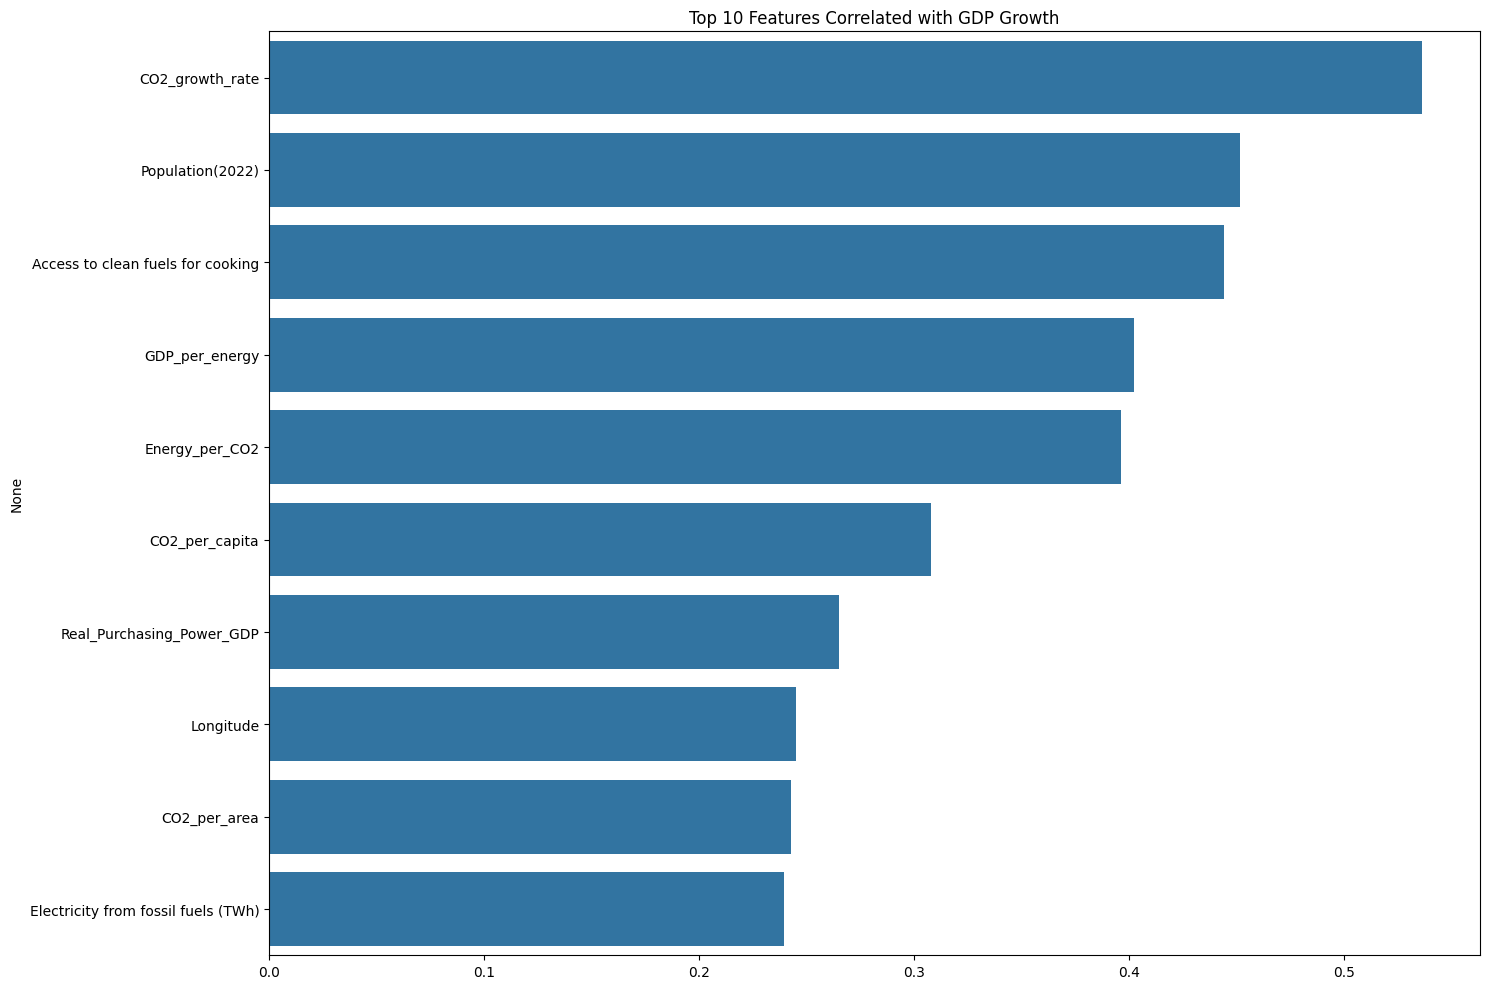


Top 10 correlated features with GDP growth:
CO2_growth_rate                        0.536653
Population(2022)                       0.451729
Access to clean fuels for cooking      0.444328
GDP_per_energy                         0.402354
Energy_per_CO2                         0.396343
CO2_per_capita                         0.308024
Real_Purchasing_Power_GDP              0.265308
Longitude                              0.245327
CO2_per_area                           0.242916
Electricity from fossil fuels (TWh)    0.239722
Name: gdp_growth, dtype: float64

Top 10 features selected by f_regression:
                                Feature       Score
24                      CO2_growth_rate  121.619004
1                      Population(2022)   67.484630
6     Access to clean fuels for cooking   66.227168
16                       Energy_per_CO2   60.920979
19                       GDP_per_energy   50.331968
15                       CO2_per_capita   29.333779
21            Real_Purchasing_Power

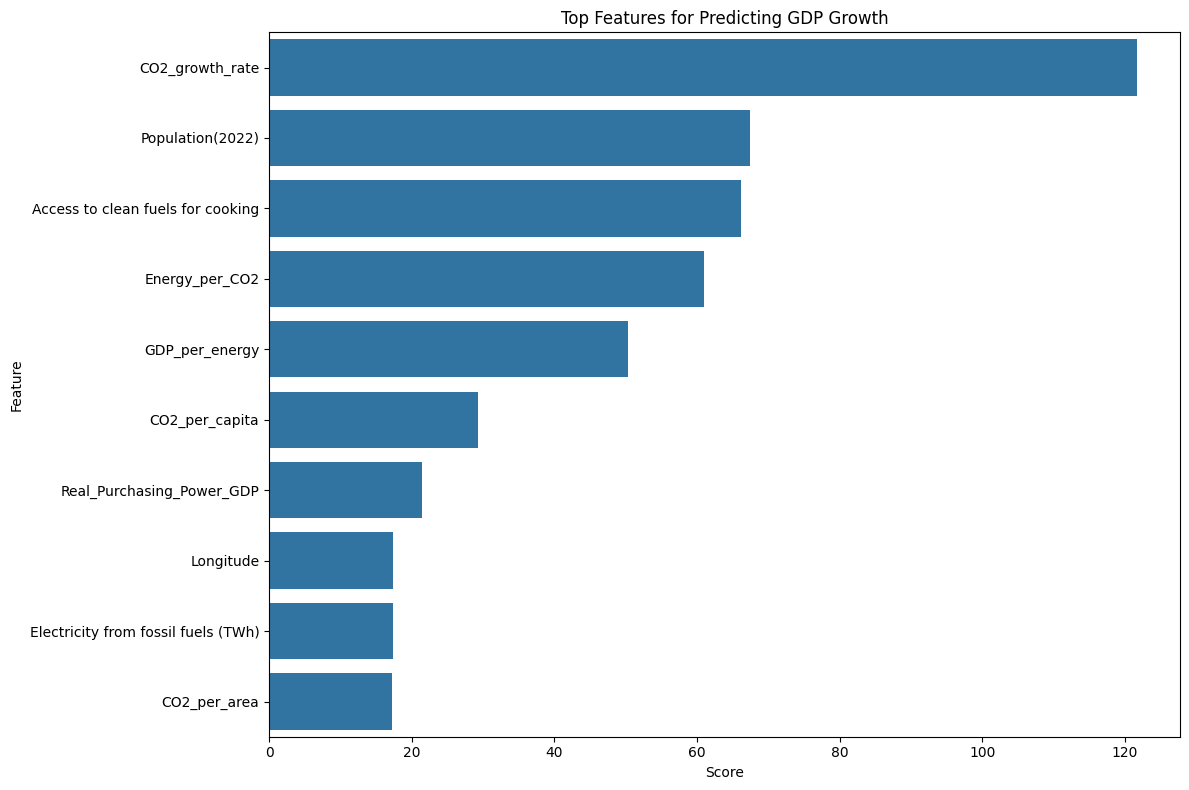


Performing Recursive Feature Elimination...
Features selected by RFE: ['Area(Square kilometre)', 'Density(Square kilometre)', 'Access to electricity (% of population)', 'Renewables (% equivalent primary energy)', 'Latitude', 'Renewable_ratio', 'CO2_per_area', 'Exchange_Rate_Volatility', 'Economic_External_Sensitivity', 'CO2_growth_rate']

Original features: 27
PCA components retained (95% variance): 12

Training models with selected features...
SVR: RMSE=3.3902, MAE=2.1818, R²=0.2589
Linear Regression: RMSE=3.3153, MAE=2.2730, R²=0.2912
ElasticNet: RMSE=3.3800, MAE=2.3459, R²=0.2633
Random Forest: RMSE=3.7089, MAE=2.3717, R²=0.1129
SVR with PCA: RMSE=3.3800, MAE=2.1059, R²=0.2633

Performing hyperparameter tuning for SVR...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'model__C': 10, 'model__epsilon': 0.2, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Best cross-validation RMSE: 2.9872
Test set performance with tuned SVR:
RMSE: 3.4573
MAE: 2.1842


<Figure size 1200x600 with 0 Axes>

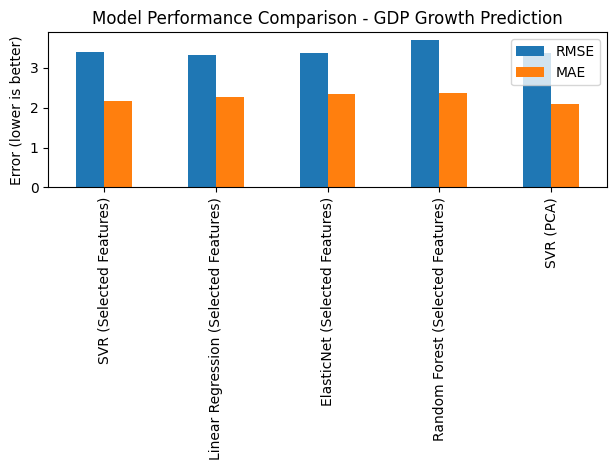

<Figure size 1200x600 with 0 Axes>

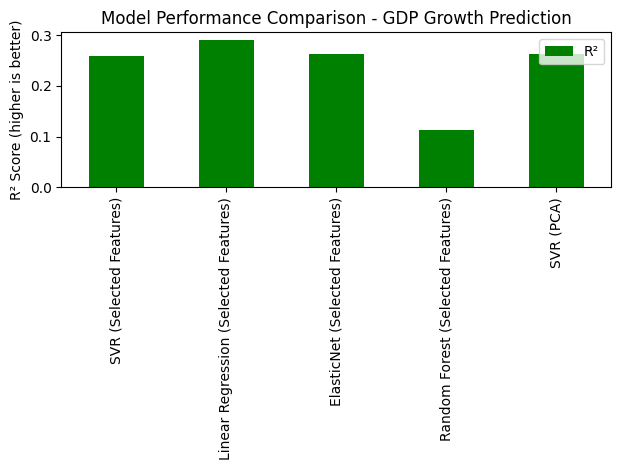

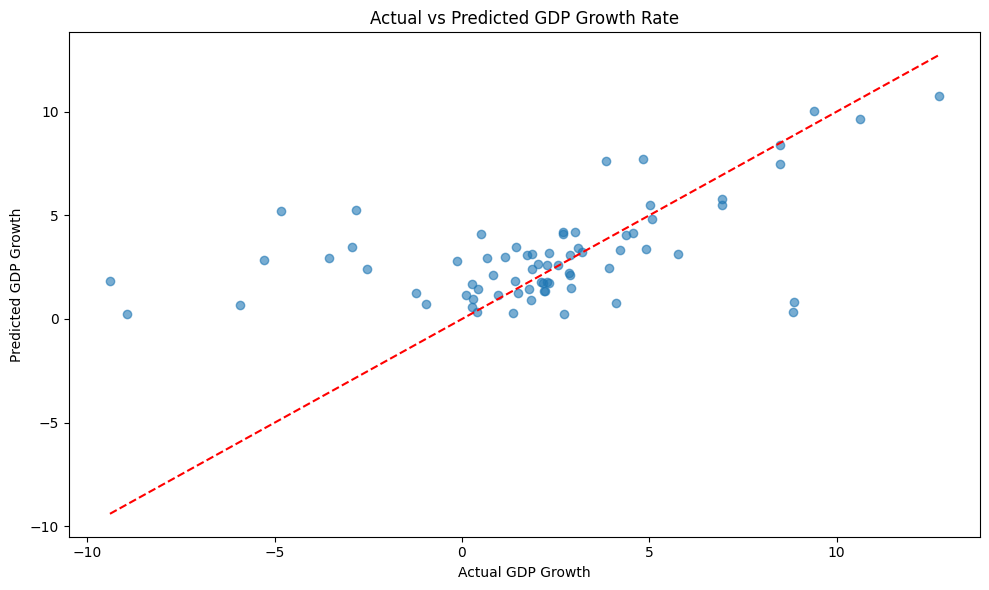

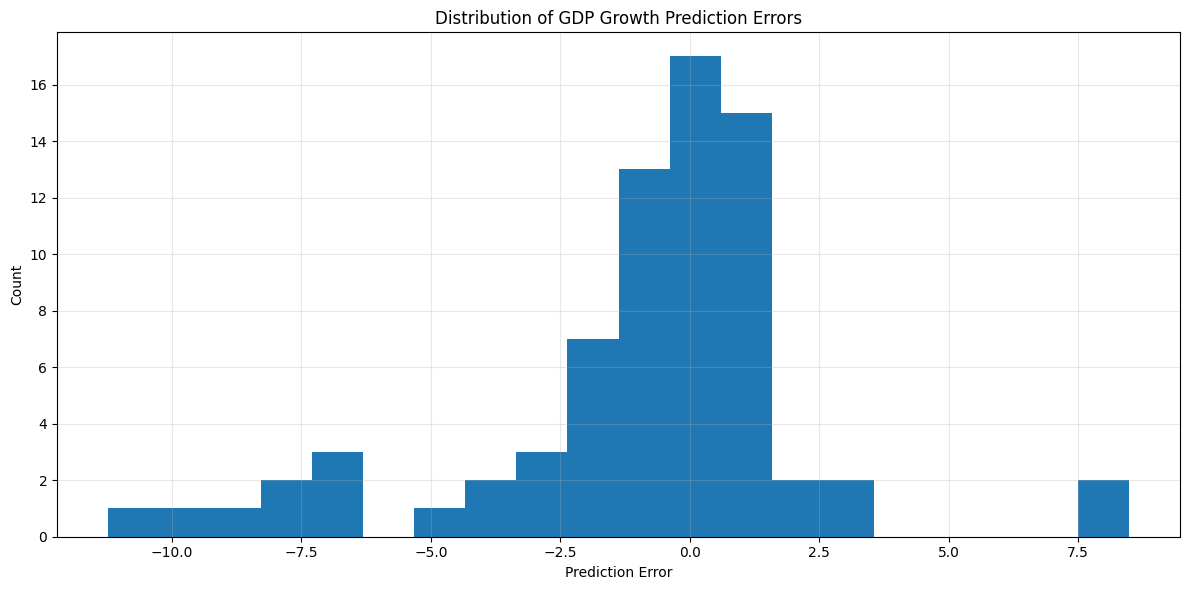

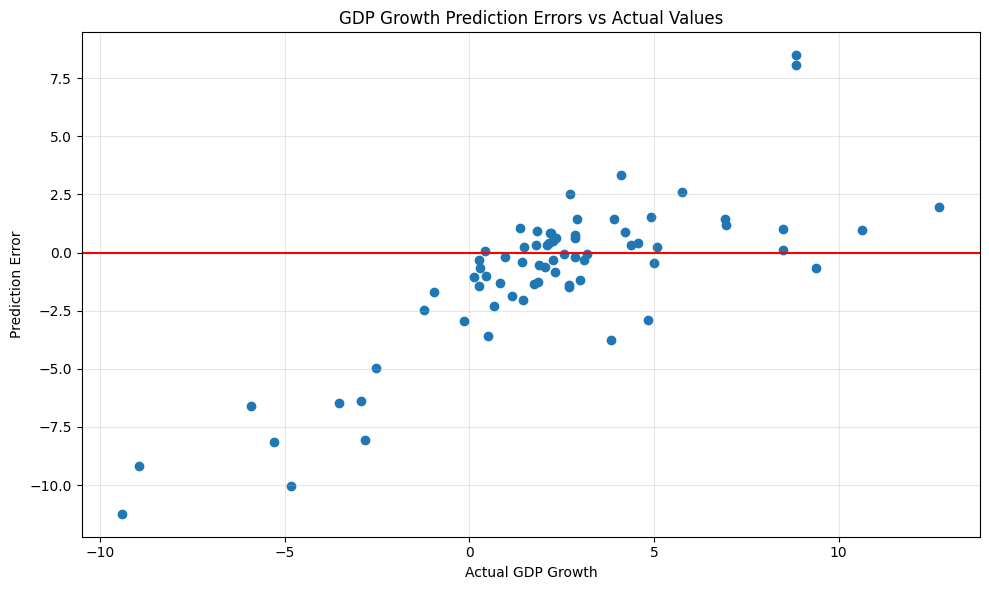


Example of prediction with adjusted features:
Original feature values for a test sample:
  CO2_growth_rate: 0.0238
  Population(2022): 123951692.0000
  Access to clean fuels for cooking: 100.0000
  Energy_per_CO2: 95.8684
  GDP_per_energy: 1.1316
  CO2_per_capita: 453.0047
  Real_Purchasing_Power_GDP: 615.9293
  Longitude: 138.2529
  Electricity from fossil fuels (TWh): 920.3900
  CO2_per_area: 148574.3279
Actual GDP growth: 1.3748
Predicted GDP growth: 0.2968

Simulating the effect of adjusting key features:
Increasing Energy_per_CO2 by 20%:
  Energy_per_CO2: 95.8684 → 115.0421
  Predicted GDP growth: 0.2968 → 0.3835
  Change in prediction: 0.0867

# Save model
joblib.dump(grid_search, 'best_model_gdp_growth.pkl')


In [10]:
# ==================================================
# GDP Growth Rate Prediction Model
# ==================================================


# Define target and features
target_column = 'gdp_growth'

# Drop irrelevant columns and direct GDP-related features to avoid data leakage
exclude_columns = ['Country', 'Year', 'gdp_growth', 'gdp_per_capita', 
                   'GDP_growth_per_capita', 'Exchange_Adjusted_GDP_Growth']

features = [col for col in new_df.columns if col not in exclude_columns]

# Check for infinity and nan values in features
print("Checking for problematic values in the data:")
inf_count = (np.isinf(new_df[features].values)).sum()
nan_count = (np.isnan(new_df[features].values)).sum()
print(f"Infinity values found: {inf_count}")
print(f"NaN values found: {nan_count}")

# Create feature and target variables
X = new_df[features].copy()
y = new_df[target_column].copy()

# Replace infinity values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check if we still have any infinity values
still_inf = (np.isinf(X.values)).sum()
print(f"Infinity values after replacement: {still_inf}")

# Handle NaN values with simple imputation
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Final check for problematic values
final_inf_count = (np.isinf(X_imputed.values)).sum()
final_nan_count = (np.isnan(X_imputed.values)).sum()
print(f"Final check - Infinity: {final_inf_count}, NaN: {final_nan_count}")

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# 1. Feature Selection - using correlation analysis
plt.figure(figsize=(15, 10))
correlation = new_df[features + [target_column]].corr()[target_column].sort_values(ascending=False)
top_correlated = correlation.drop(target_column).abs().sort_values(ascending=False).head(10)
sns.barplot(x=top_correlated.values, y=top_correlated.index)
plt.title('Top 10 Features Correlated with GDP Growth')
plt.tight_layout()
plt.show()

print("\nTop 10 correlated features with GDP growth:")
print(top_correlated)

# 2. Feature Selection using SelectKBest (f_regression)
k = 10  # Number of top features to select
selector = SelectKBest(f_regression, k=k)
X_train_scaled = StandardScaler().fit_transform(X_train)
selector.fit(X_train_scaled, y_train)

# Get selected feature names
feature_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'Score': selector.scores_
}).sort_values('Score', ascending=False)

selected_features = feature_scores.head(k)['Feature'].tolist()

print("\nTop 10 features selected by f_regression:")
print(feature_scores.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=feature_scores.head(k))
plt.title('Top Features for Predicting GDP Growth')
plt.tight_layout()
plt.show()

# 3. Recursive Feature Elimination (alternative to SelectKBest)
print("\nPerforming Recursive Feature Elimination...")
estimator = SVR(kernel='linear')
rfe = RFE(estimator, n_features_to_select=k, step=1)
rfe.fit(X_train_scaled, y_train)

# Get selected features from RFE
rfe_features = [X_train.columns[i] for i, selected in enumerate(rfe.support_) if selected]
print("Features selected by RFE:", rfe_features)

# 4. Reduce dimensionality with PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_scaled = StandardScaler().fit_transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

print(f"\nOriginal features: {X_train.shape[1]}")
print(f"PCA components retained (95% variance): {pca.n_components_}")

# 5. Train Models
# We'll train on both selected features and PCA-transformed features
# Focus on SVR as specified in the requirements

# 5.1 Models with Selected Features
print("\nTraining models with selected features...")
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Fix the Ridge issue by using a different regularized linear model
from sklearn.linear_model import RidgeCV, ElasticNet

# Compare SVR with other models for reference
models = {
    'SVR': SVR(),
    'Linear Regression': LinearRegression(),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.1),  # Using ElasticNet instead of Ridge
    'Random Forest': RandomForestRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    try:
        # Create pipeline with scaling
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        
        # Train and predict
        pipeline.fit(X_train_selected, y_train)
        y_pred = pipeline.predict(X_test_selected)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results[f"{name} (Selected Features)"] = {
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2
        }
        
        print(f"{name}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")
    except Exception as e:
        print(f"Error training {name}: {e}")

# 5.2 SVR with PCA for comparison
try:
    svr = SVR()
    svr.fit(X_train_pca, y_train)
    y_pred_pca = svr.predict(X_test_pca)

    mse_pca = mean_squared_error(y_test, y_pred_pca)
    rmse_pca = np.sqrt(mse_pca)
    mae_pca = mean_absolute_error(y_test, y_pred_pca)
    r2_pca = r2_score(y_test, y_pred_pca)

    results["SVR (PCA)"] = {
        'RMSE': rmse_pca,
        'MAE': mae_pca,
        'R²': r2_pca
    }

    print(f"SVR with PCA: RMSE={rmse_pca:.4f}, MAE={mae_pca:.4f}, R²={r2_pca:.4f}")
except Exception as e:
    print(f"Error training SVR with PCA: {e}")

# 6. Perform extensive hyperparameter tuning for SVR
print("\nPerforming hyperparameter tuning for SVR...")

# Define parameter grid for SVR
param_grid = {
    'model__kernel': ['linear', 'rbf'],  # Simplified grid for faster execution
    'model__C': [0.1, 1, 10],
    'model__gamma': ['scale', 'auto'],
    'model__epsilon': [0.1, 0.2]
}

# Create pipeline for SVR
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR())
])

# Perform grid search
try:
    grid_search = GridSearchCV(
        svr_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train_selected, y_train)

    # Get best parameters and performance
    print("Best parameters:", grid_search.best_params_)
    best_score = np.sqrt(-grid_search.best_score_)
    print(f"Best cross-validation RMSE: {best_score:.4f}")

    # Evaluate on test set
    y_pred_best = grid_search.predict(X_test_selected)
    mse_best = mean_squared_error(y_test, y_pred_best)
    rmse_best = np.sqrt(mse_best)
    r2_best = r2_score(y_test, y_pred_best)
    mae_best = mean_absolute_error(y_test, y_pred_best)

    print(f"Test set performance with tuned SVR:")
    print(f"RMSE: {rmse_best:.4f}")
    print(f"MAE: {mae_best:.4f}")
    print(f"R²: {r2_best:.4f}")
except Exception as e:
    print(f"Error in SVR hyperparameter tuning: {e}")
    # Fallback to the best model from basic training
    best_model_name = max(results, key=lambda x: results[x]['R²'])
    print(f"Using {best_model_name} as fallback")
    grid_search = models[best_model_name.split(' ')[0]]

# 7. Visualize model performance if we have results
if results:
    # Compare model performance (RMSE and MAE)
    plt.figure(figsize=(12, 6))
    metrics_df = pd.DataFrame(results).T
    metrics_df[['RMSE', 'MAE']].plot(kind='bar')
    plt.title('Model Performance Comparison - GDP Growth Prediction')
    plt.ylabel('Error (lower is better)')
    plt.tight_layout()
    plt.show()

    # Compare model performance (R²)
    plt.figure(figsize=(12, 6))
    metrics_df[['R²']].plot(kind='bar', color='green')
    plt.title('Model Performance Comparison - GDP Growth Prediction')
    plt.ylabel('R² Score (higher is better)')
    plt.tight_layout()
    plt.show()


# 8. Visualize actual vs predicted values for the best model
if 'grid_search' in locals() and 'y_pred_best' in locals():
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_best, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual GDP Growth')
    plt.ylabel('Predicted GDP Growth')
    plt.title('Actual vs Predicted GDP Growth Rate')
    plt.tight_layout()
    plt.show()

    # 9. Analyze SVR model errors
    errors = y_test - y_pred_best
    plt.figure(figsize=(12, 6))
    plt.hist(errors, bins=20)
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')
    plt.title('Distribution of GDP Growth Prediction Errors')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot errors against actual values to check for patterns
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, errors)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Actual GDP Growth')
    plt.ylabel('Prediction Error')
    plt.title('GDP Growth Prediction Errors vs Actual Values')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 10. Create an interactive prediction example (mock-up)
    print("\nExample of prediction with adjusted features:")

    try:
        # Use the first test sample as an example
        example = X_test_selected.iloc[0].copy()
        actual_value = y_test.iloc[0]

        # Make prediction with original values
        original_prediction = grid_search.predict([example])[0]

        print(f"Original feature values for a test sample:")
        for feature in selected_features:
            print(f"  {feature}: {example[feature]:.4f}")
        print(f"Actual GDP growth: {actual_value:.4f}")
        print(f"Predicted GDP growth: {original_prediction:.4f}")

        # Demonstrate effect of adjusting key features if they are in selected features
        adjustment_features = []
        if 'Exchange_Rate_Volatility' in selected_features:
            adjustment_features.append('Exchange_Rate_Volatility')
        if 'Energy_per_CO2' in selected_features:
            adjustment_features.append('Energy_per_CO2')

        if adjustment_features:
            print("\nSimulating the effect of adjusting key features:")
            for feature in adjustment_features:
                # Increase the feature by 20%
                modified_example = example.copy()
                modified_example[feature] *= 1.2
                modified_prediction = grid_search.predict([modified_example])[0]
                
                print(f"Increasing {feature} by 20%:")
                print(f"  {feature}: {example[feature]:.4f} → {modified_example[feature]:.4f}")
                print(f"  Predicted GDP growth: {original_prediction:.4f} → {modified_prediction:.4f}")
                print(f"  Change in prediction: {modified_prediction - original_prediction:.4f}")
    except Exception as e:
        print(f"Error in prediction example: {e}")

# Save the best model 
try:
    import joblib
    if 'grid_search' in locals():
        joblib.dump(grid_search, 'best_model_gdp_growth.pkl')
        print("\n# Save model")
        print("joblib.dump(grid_search, 'best_model_gdp_growth.pkl')")
    else:
        # Find the best model from basic training
        best_model_name = max(results, key=lambda x: results[x]['R²'])
        best_model_key = best_model_name.split(' ')[0]
        best_model = models[best_model_key]
        
        # Create a pipeline with scaler
        best_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', best_model)
        ])
        
        # Fit the pipeline
        best_pipeline.fit(X_train_selected, y_train)
        
        # Save the pipeline
        joblib.dump(best_pipeline, 'best_model_gdp_growth.pkl')
        print("\n# Save model")
        print("joblib.dump(best_pipeline, 'best_model_gdp_growth.pkl')")
except Exception as e:
    print(f"Error saving model: {e}")

## Classification of High Carbon Emission Countries

Building High Carbon Emission Country Classification Model
Duplicate rows in dataset: 0
Global mean CO2 per capita: 406.91

Class distribution:
High emission countries (1): 144 (40.3%)
Low emission countries (0): 213 (59.7%)


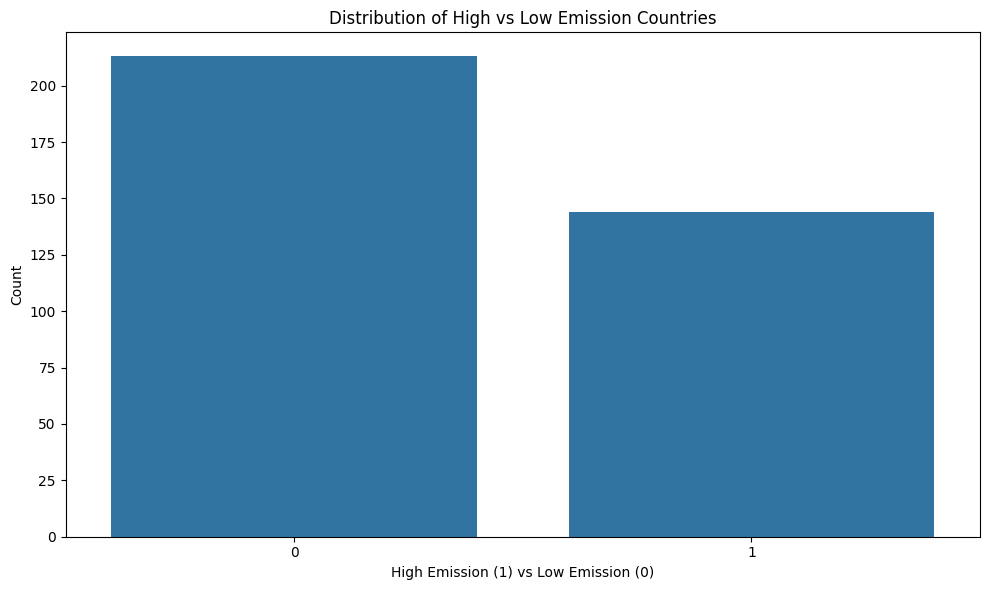


Checking for problematic values in the data:
Infinity values found: 9
NaN values found: 0

Found 3 highly correlated features (>0.9):
['proportion of global land area', 'Renewable_ratio', 'Exchange_Adjusted_GDP_Growth']
Removed highly correlated features to prevent multicollinearity
After cleaning - Infinity: 0, NaN: 0

Top 8 features for classification:
                                              Feature     Score
0                                    Population(2022)  0.583774
13                                          Longitude  0.582469
2                           Density(Square kilometre)  0.578717
1                              Area(Square kilometre)  0.578441
12                                           Latitude  0.562923
11                                     gdp_per_capita  0.513176
8   Primary energy consumption per capita (kWh/per...  0.473343
17                          Real_Purchasing_Power_GDP  0.436198


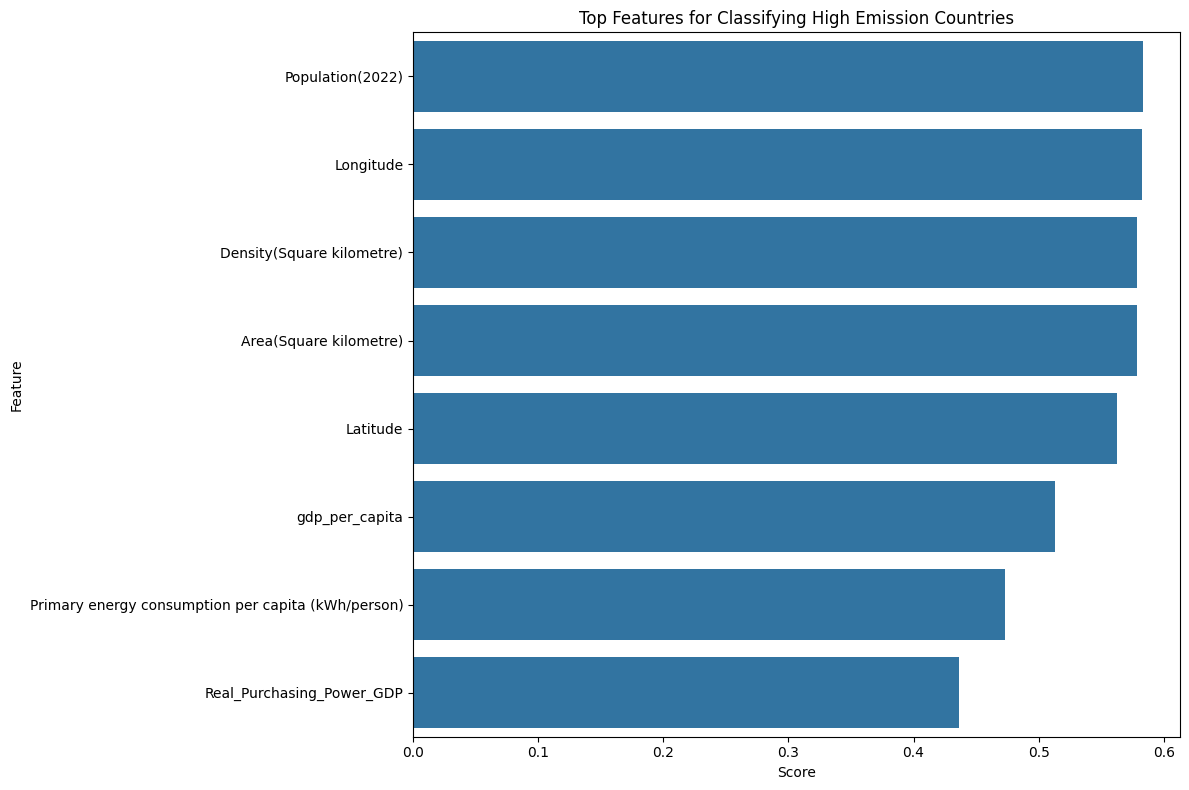


Original features: 22
PCA components retained (90% variance): 10

Training Logistic Regression...
Cross-validation F1 scores: [0.84210526 0.7        0.9        0.76190476 0.95238095 0.8
 0.86956522 0.81818182 0.84210526 1.        ]
Mean CV F1 score: 0.8486 (±0.0835)
Test Accuracy: 0.8889
Test Precision: 0.8478
Test Recall: 0.8864
Test F1 Score: 0.8667


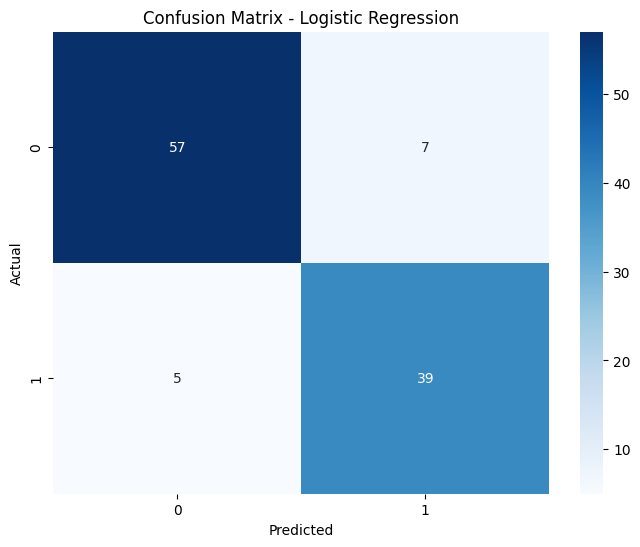

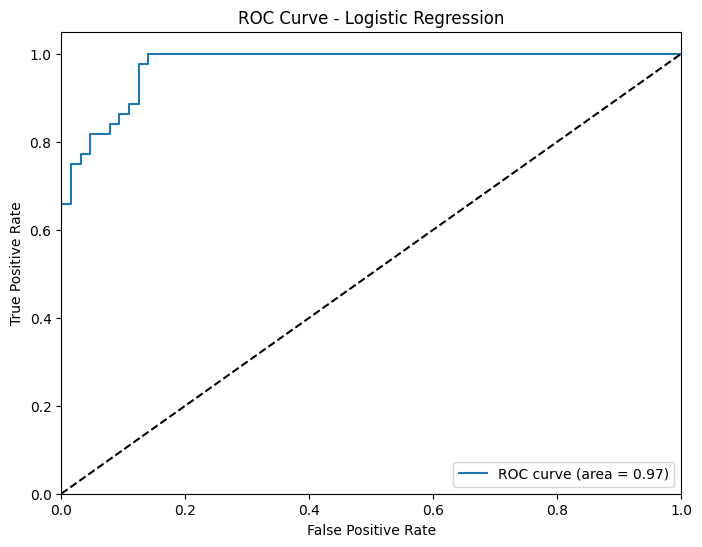


Training Random Forest...
Cross-validation F1 scores: [0.94736842 0.9        0.94736842 0.94736842 0.95238095 0.81818182
 1.         0.95238095 0.88888889 0.94736842]
Mean CV F1 score: 0.9301 (±0.0471)
Test Accuracy: 0.9815
Test Precision: 1.0000
Test Recall: 0.9545
Test F1 Score: 0.9767


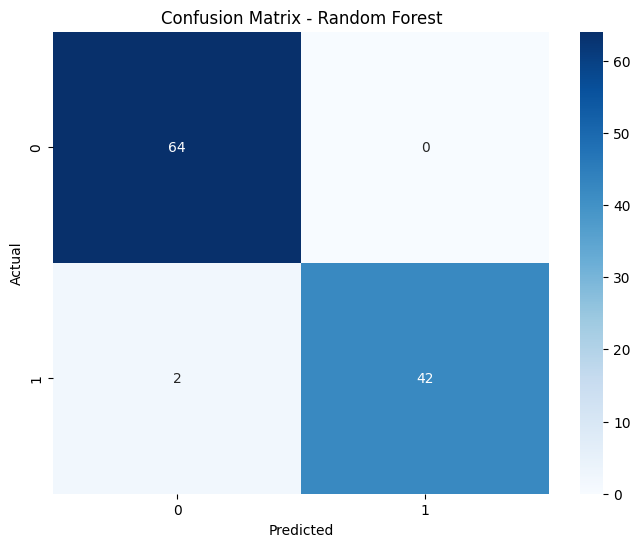

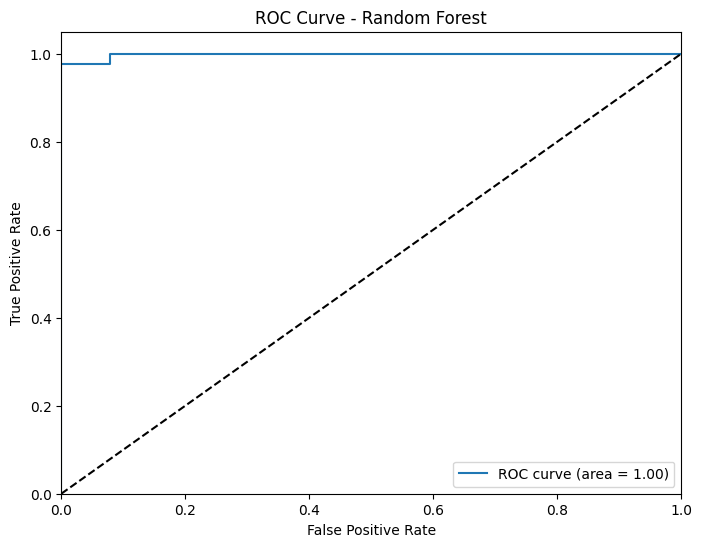


Training SVM...
Cross-validation F1 scores: [0.84210526 0.90909091 0.86956522 0.81818182 0.95238095 0.7826087
 0.90909091 0.90909091 0.84210526 1.        ]
Mean CV F1 score: 0.8834 (±0.0619)
Test Accuracy: 0.9352
Test Precision: 0.8627
Test Recall: 1.0000
Test F1 Score: 0.9263


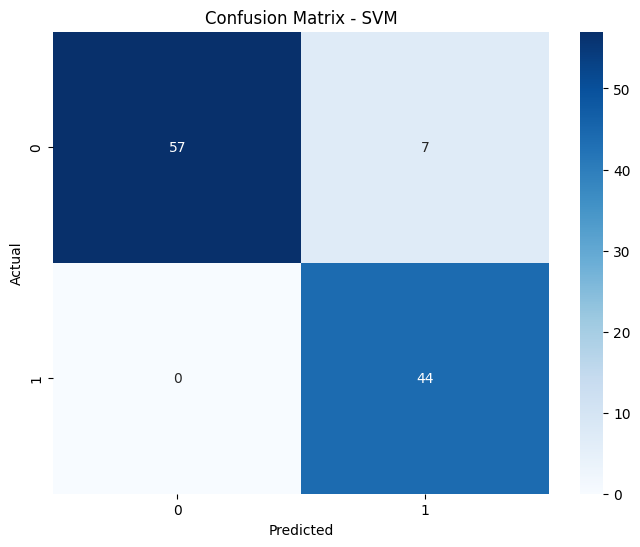

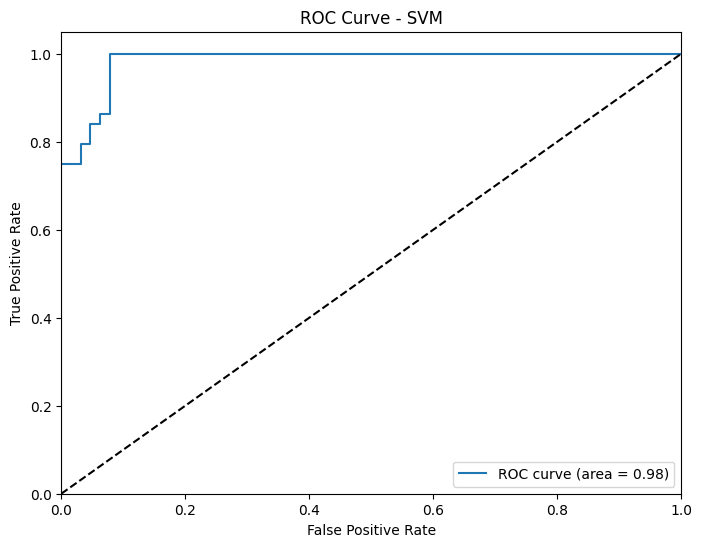

<Figure size 1400x800 with 0 Axes>

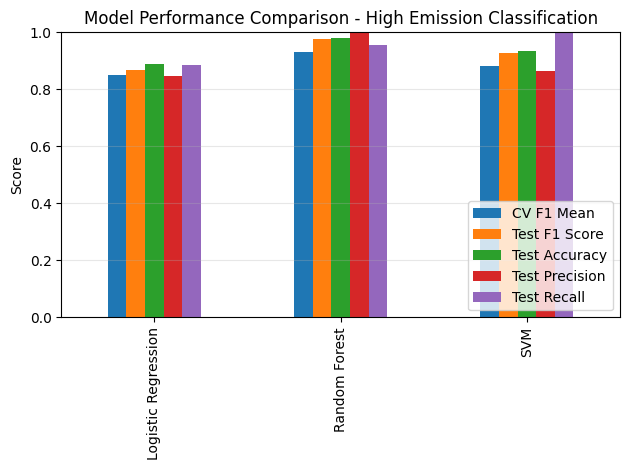

<Figure size 1000x600 with 0 Axes>

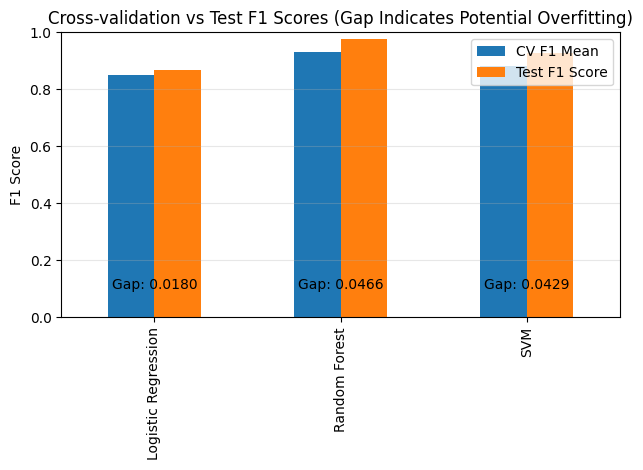


Best model based on CV F1 Score: Random Forest
CV F1 Score: 0.9301
Test F1 Score: 0.9767
Performing hyperparameter tuning for Random Forest...
Best parameters: {'classifier__max_depth': 5, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best cross-validation F1 Score: 0.9444
Training F1 Score: 0.9675
Training-CV gap: 0.0231
Test set performance with tuned model:
Accuracy: 0.9630
Precision: 1.0000
Recall: 0.9091
F1 Score: 0.9524


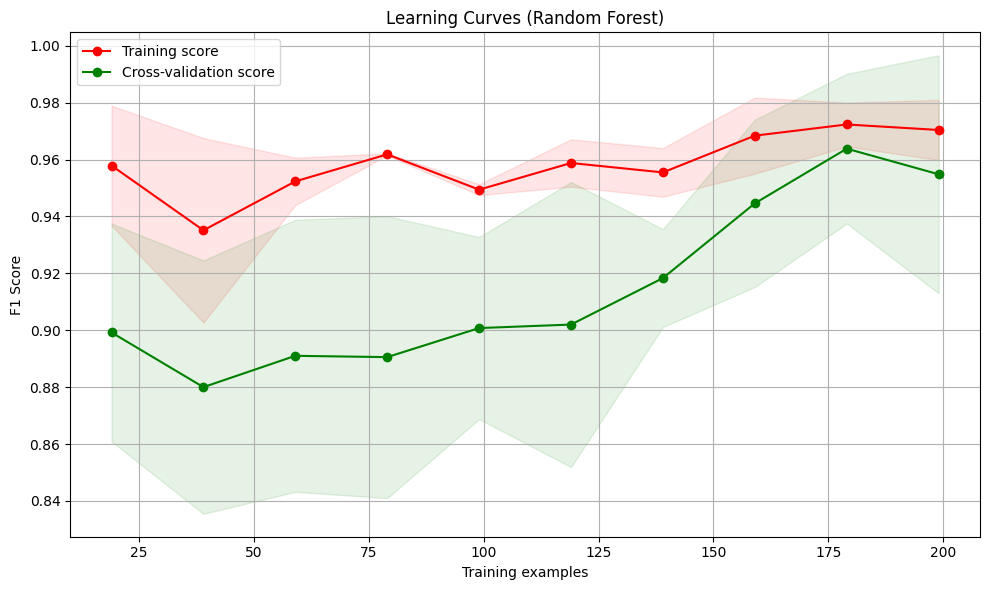

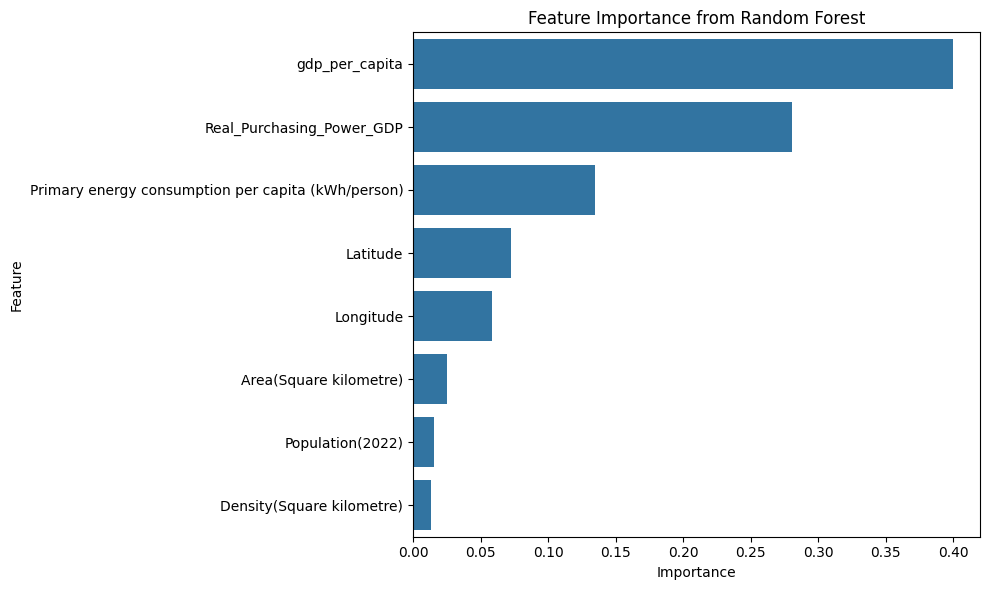


Final model feature importance:
                                             Feature  Importance
5                                     gdp_per_capita    0.399879
7                          Real_Purchasing_Power_GDP    0.280563
6  Primary energy consumption per capita (kWh/per...    0.134947
4                                           Latitude    0.072450
1                                          Longitude    0.058538
3                             Area(Square kilometre)    0.025264
0                                   Population(2022)    0.015194
2                          Density(Square kilometre)    0.013165

Simulating the effect of carbon tax policy:

Simulating policy impact on a high-emission country sample:
                                             Feature Improvement  \
0  Primary energy consumption per capita (kWh/per...          5%   
1  Primary energy consumption per capita (kWh/per...         10%   
2  Primary energy consumption per capita (kWh/per...         15%   
3  P

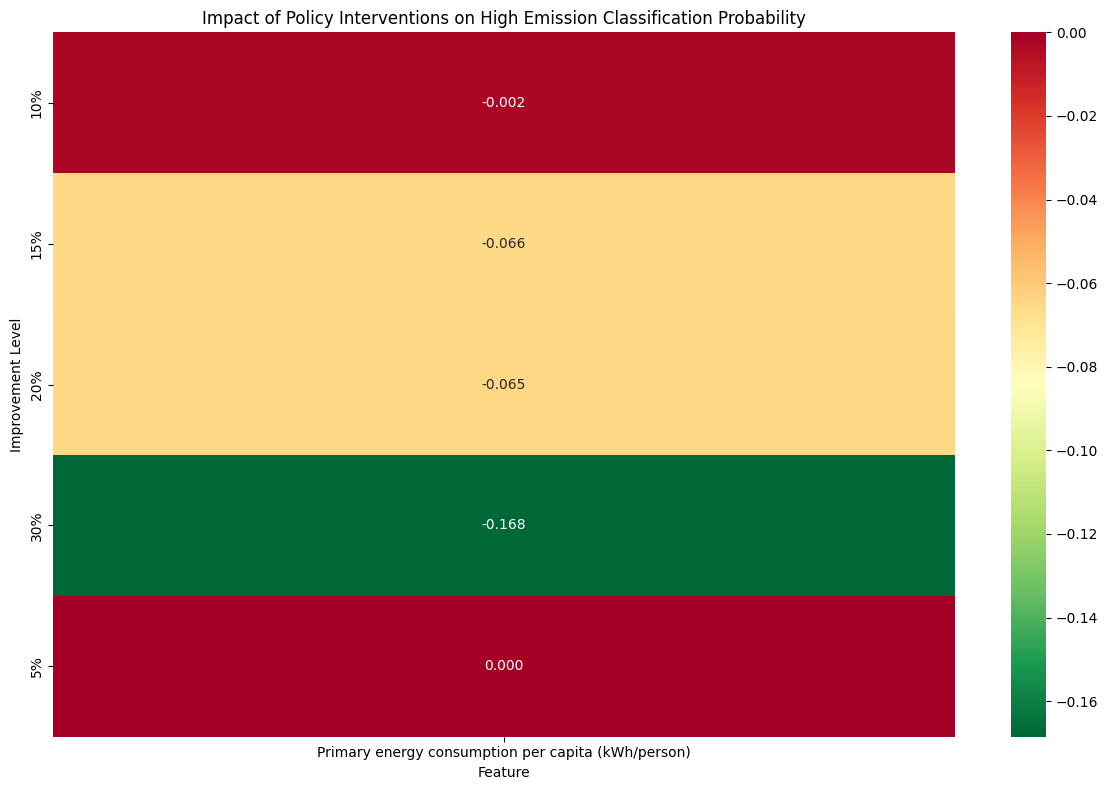


# Save model
joblib.dump(grid_search, 'best_classifier_high_emission.pkl')


In [11]:
# ==================================================
# High Carbon Emission Country Classification Model
# ==================================================

print("=" * 50)
print("Building High Carbon Emission Country Classification Model")
print("=" * 50)


# Check for duplicate rows which could contribute to overfitting
duplicates = new_df.duplicated().sum()
print(f"Duplicate rows in dataset: {duplicates}")
if duplicates > 0:
    new_df = new_df.drop_duplicates()
    print("Removed duplicate rows")

# 1. Create binary target variable
# Calculate global mean CO2 per capita
global_mean = new_df['CO2_per_capita'].mean()
print(f"Global mean CO2 per capita: {global_mean:.2f}")

# Create binary target: 1 for high emissions (above global mean), 0 for low
new_df['high_emission'] = (new_df['CO2_per_capita'] > global_mean).astype(int)

# Check class distribution
class_counts = new_df['high_emission'].value_counts()
print("\nClass distribution:")
print(f"High emission countries (1): {class_counts[1]} ({class_counts[1]/len(new_df)*100:.1f}%)")
print(f"Low emission countries (0): {class_counts[0]} ({class_counts[0]/len(new_df)*100:.1f}%)")

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='high_emission', data=new_df)
plt.title('Distribution of High vs Low Emission Countries')
plt.xlabel('High Emission (1) vs Low Emission (0)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 2. Define features and target
target_column = 'high_emission'

# Drop irrelevant columns and CO2-related features to avoid data leakage
exclude_columns = ['Country', 'Year', 'high_emission', 'CO2_per_capita', 
                   'CO2 emission (Tons)', 'CO2_per_GDP', 'CO2_per_area', 
                   'CO2_growth_rate', 'CO2_trend']

features = [col for col in new_df.columns if col not in exclude_columns]

# Check for problematic values in features
print("\nChecking for problematic values in the data:")
inf_count = np.sum(np.isinf(new_df[features].values))
nan_count = np.sum(np.isnan(new_df[features].values))
print(f"Infinity values found: {inf_count}")
print(f"NaN values found: {nan_count}")

# Create feature and target variables with proper data cleaning
X = new_df[features].copy()
y = new_df[target_column].copy()

# Replace infinity values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Handle NaN values with imputation
imputer = SimpleImputer(strategy='median')  # Median is more robust to outliers
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Check for highly correlated features
corr_matrix = X_imputed.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.9)]

if high_corr_features:
    print(f"\nFound {len(high_corr_features)} highly correlated features (>0.9):")
    print(high_corr_features)
    # Remove one of each pair of highly correlated features
    X_imputed = X_imputed.drop(columns=high_corr_features)
    print(f"Removed highly correlated features to prevent multicollinearity")
    features = X_imputed.columns.tolist()

# Final check for problematic values
final_inf_count = np.sum(np.isinf(X_imputed.values))
final_nan_count = np.sum(np.isnan(X_imputed.values))
print(f"After cleaning - Infinity: {final_inf_count}, NaN: {final_nan_count}")

# 3. Split into training and testing sets with larger test size to better assess generalization
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42, stratify=y)

# 4. Feature Selection
# 4.1 Using mutual information which can capture non-linear relationships
k = min(8, len(features))  # Reduce from 10 to 8 to further limit model complexity

# Create and fit one scaler for both train and test sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Now using the fitted scaler

# Apply feature selection
selector = SelectKBest(mutual_info_classif, k=k)
selector.fit(X_train_scaled, y_train)

# Get selected feature names and transform data
feature_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'Score': selector.scores_
}).sort_values('Score', ascending=False)

selected_features = feature_scores.head(k)['Feature'].tolist()

print(f"\nTop {k} features for classification:")
print(feature_scores.head(k))

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=feature_scores.head(k))
plt.title('Top Features for Classifying High Emission Countries')
plt.tight_layout()
plt.show()

# Get selected data
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# 4.2 Apply PCA for dimensionality reduction
pca_scaler = StandardScaler()
X_train_pca_scaled = pca_scaler.fit_transform(X_train)
X_test_pca_scaled = pca_scaler.transform(X_test)

pca = PCA(n_components=0.9)  # Reduce from 0.95 to 0.9 to further constrain the model
X_train_pca = pca.fit_transform(X_train_pca_scaled)
X_test_pca = pca.transform(X_test_pca_scaled)

print(f"\nOriginal features: {X_train.shape[1]}")
print(f"PCA components retained (90% variance): {pca.n_components_}")

# 5. Train Models
# Define classifiers with strong regularization to prevent overfitting
classifiers = {
    'Logistic Regression': LogisticRegression(
        max_iter=2000, 
        C=1.0,                  # Regularization strength
        class_weight='balanced', # Handle class imbalance
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=4,               # Limit tree depth to prevent overfitting
        min_samples_split=10,      # Require more samples for a split
        min_samples_leaf=8,        # Require more samples in a leaf
        max_features='sqrt',       # Limit features considered per split
        class_weight='balanced',   # Handle potential class imbalance
        random_state=42
    ),
    'SVM': SVC(
        probability=True, 
        C=1.0,                  # Regularization parameter
        gamma='scale',          # Kernel coefficient
        class_weight='balanced', # Handle class imbalance
        random_state=42
    )
}

# Create stratified k-fold cross-validation to ensure robust evaluation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Train and evaluate each classifier
results = {}

for name, classifier in classifiers.items():
    try:
        print(f"\nTraining {name}...")
        
        # Create pipeline with scaling
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', classifier)
        ])
        
        # Cross-validation to get a more robust performance estimate
        cv_scores = cross_val_score(pipeline, X_train_selected, y_train, cv=cv, scoring='f1')
        print(f"Cross-validation F1 scores: {cv_scores}")
        print(f"Mean CV F1 score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
        
        # Train the model
        pipeline.fit(X_train_selected, y_train)
        
        # Make predictions
        y_pred = pipeline.predict(X_test_selected)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Store results
        results[name] = {
            'CV F1 Mean': cv_scores.mean(),
            'CV F1 Std': cv_scores.std(),
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Pipeline': pipeline
        }
        
        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Test Precision: {precision:.4f}")
        print(f"Test Recall: {recall:.4f}")
        print(f"Test F1 Score: {f1:.4f}")
        
        # Check for potential overfitting
        if f1 > cv_scores.mean() + 2 * cv_scores.std():
            print(f"WARNING: Model may be overfitting (test F1 significantly higher than CV F1)")
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        # ROC Curve
        if hasattr(pipeline, "predict_proba"):
            y_proba = pipeline.predict_proba(X_test_selected)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {name}')
            plt.legend(loc="lower right")
            plt.show()
    except Exception as e:
        print(f"Error training {name}: {e}")

# 6. Compare model performance if we have results
if results:
    # Remove pipeline from results for DataFrame creation
    plot_results = {k: {k2: v2 for k2, v2 in v.items() if k2 != 'Pipeline'} for k, v in results.items()}
    metrics_df = pd.DataFrame(plot_results).T
    
    # Add CV-to-test F1 difference to identify overfitting
    metrics_df['F1 CV-Test Gap'] = metrics_df['Test F1 Score'] - metrics_df['CV F1 Mean']
    
    # Plot performance comparison
    plt.figure(figsize=(14, 8))
    metrics_cols = ['CV F1 Mean', 'Test F1 Score', 'Test Accuracy', 'Test Precision', 'Test Recall']
    metrics_df[metrics_cols].plot(kind='bar')
    plt.title('Model Performance Comparison - High Emission Classification')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    
    # Plot CV vs Test scores to visualize potential overfitting
    plt.figure(figsize=(10, 6))
    metrics_df[['CV F1 Mean', 'Test F1 Score']].plot(kind='bar')
    plt.title('Cross-validation vs Test F1 Scores (Gap Indicates Potential Overfitting)')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    for i, model in enumerate(metrics_df.index):
        gap = metrics_df.loc[model, 'F1 CV-Test Gap']
        plt.text(i, 0.1, f'Gap: {gap:.4f}', ha='center')
    plt.tight_layout()
    plt.show()

    # 7. Hyperparameter Tuning for the best model
    try:
        # Select best model based on CV performance, not test performance to avoid overfitting
        best_model_name = max(results, key=lambda x: results[x]['CV F1 Mean'])
        print(f"\nBest model based on CV F1 Score: {best_model_name}")
        print(f"CV F1 Score: {results[best_model_name]['CV F1 Mean']:.4f}")
        print(f"Test F1 Score: {results[best_model_name]['Test F1 Score']:.4f}")

        # Define stricter parameter grids for each classifier
        param_grids = {
            'Logistic Regression': {
                'classifier__C': [0.01, 0.1, 1.0, 10.0],
                'classifier__class_weight': ['balanced', None],
                'classifier__solver': ['liblinear', 'saga']
            },
            'Random Forest': {
                'classifier__n_estimators': [50, 100, 200],
                'classifier__max_depth': [3, 4, 5, 6],  # Constrain depth further
                'classifier__min_samples_split': [5, 10, 15],
                'classifier__min_samples_leaf': [4, 8, 12],
                'classifier__max_features': ['sqrt', 'log2']
            },
            'SVM': {
                'classifier__C': [0.1, 1.0, 10.0],
                'classifier__gamma': ['scale', 'auto'],
                'classifier__class_weight': ['balanced', None]
            }
        }

        # Get parameter grid for the best model
        param_grid = param_grids[best_model_name]

        # Create a new pipeline for the best model
        best_classifier = classifiers[best_model_name]
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', best_classifier)
        ])

        # Perform grid search with cross-validation
        print(f"Performing hyperparameter tuning for {best_model_name}...")
        grid_search = GridSearchCV(
            pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1,
            return_train_score=True  # Important to assess overfitting
        )
        grid_search.fit(X_train_selected, y_train)

        # Get best parameters and performance
        print("Best parameters:", grid_search.best_params_)
        best_cv_score = grid_search.best_score_
        print(f"Best cross-validation F1 Score: {best_cv_score:.4f}")
        
        # Get training score to check for overfitting
        best_idx = grid_search.best_index_
        train_score = grid_search.cv_results_['mean_train_score'][best_idx]
        print(f"Training F1 Score: {train_score:.4f}")
        print(f"Training-CV gap: {train_score - best_cv_score:.4f}")
        
        if train_score - best_cv_score > 0.1:
            print("WARNING: Model still shows signs of overfitting (large gap between training and CV scores)")

        # Evaluate on test set
        y_pred_best = grid_search.predict(X_test_selected)
        accuracy_best = accuracy_score(y_test, y_pred_best)
        precision_best = precision_score(y_test, y_pred_best)
        recall_best = recall_score(y_test, y_pred_best)
        f1_best = f1_score(y_test, y_pred_best)

        print(f"Test set performance with tuned model:")
        print(f"Accuracy: {accuracy_best:.4f}")
        print(f"Precision: {precision_best:.4f}")
        print(f"Recall: {recall_best:.4f}")
        print(f"F1 Score: {f1_best:.4f}")
        
        # Check for overfitting again
        if f1_best > best_cv_score + 0.05:
            print("WARNING: Tuned model may still be overfitting (test score significantly higher than CV score)")

        # 8. Learning curves to visualize overfitting
        from sklearn.model_selection import learning_curve
        
        train_sizes, train_scores, test_scores = learning_curve(
            grid_search.best_estimator_, X_train_selected, y_train, 
            cv=5, scoring='f1', n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 10)
        )
        
        # Calculate mean and std for the training scores
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        
        # Calculate mean and std for the test scores
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)
        
        # Plot learning curve
        plt.figure(figsize=(10, 6))
        plt.grid()
        plt.fill_between(train_sizes, train_mean - train_std,
                         train_mean + train_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_mean - test_std,
                         test_mean + test_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
        plt.title(f"Learning Curves ({best_model_name})")
        plt.xlabel("Training examples")
        plt.ylabel("F1 Score")
        plt.legend(loc="best")
        plt.tight_layout()
        plt.show()

        
        # 9. Analyze feature importance for the final model (if applicable)
        if best_model_name == 'Random Forest':
            # Extract the trained classifier
            best_model_fitted = grid_search.best_estimator_.named_steps['classifier']
            importances = best_model_fitted.feature_importances_
            feature_importance = pd.DataFrame({
                'Feature': selected_features,
                'Importance': importances
            }).sort_values('Importance', ascending=False)
            
            plt.figure(figsize=(10, 6))
            sns.barplot(x='Importance', y='Feature', data=feature_importance)
            plt.title(f'Feature Importance from {best_model_name}')
            plt.tight_layout()
            plt.show()
            
            print("\nFinal model feature importance:")
            print(feature_importance)

        # 10. Visualization for policy recommendation (simulating carbon tax impact)
        print("\nSimulating the effect of carbon tax policy:")

        # Use a representative high-emission country sample
        high_emission_samples = X_test_selected[y_test == 1]
        if len(high_emission_samples) > 0:
            sample_idx = high_emission_samples.index[0]
            sample = high_emission_samples.loc[sample_idx].copy()
            
            # Get original prediction probability
            original_proba = grid_search.predict_proba([sample])[0][1]
            
            # List of features that might be affected by carbon tax
            carbon_tax_features = [
                'Primary energy consumption per capita (kWh/person)',
                'GDP_per_energy',
                'energy_efficiency'
            ]
            
            # Keep only features that are in our selected feature set
            carbon_tax_features = [f for f in carbon_tax_features if f in selected_features]
            
            if carbon_tax_features:
                print(f"\nSimulating policy impact on a high-emission country sample:")
                impact_results = []
                
                # Try different levels of improvement
                improvement_levels = [0.05, 0.1, 0.15, 0.2, 0.3]
                
                for feature in carbon_tax_features:
                    for level in improvement_levels:
                        # Create a modified sample with improved feature value
                        modified_sample = sample.copy()
                        
                        # Determine direction of change based on feature
                        if feature in ['energy_efficiency', 'GDP_per_energy']:
                            # Higher is better, increase the value
                            modified_sample[feature] *= (1 + level)
                        else:
                            # Lower is better for energy consumption, decrease the value
                            modified_sample[feature] *= (1 - level)
                        
                        # Get new prediction probability
                        new_proba = grid_search.predict_proba([modified_sample])[0][1]
                        
                        # Calculate change in probability
                        delta = new_proba - original_proba
                        
                        impact_results.append({
                            'Feature': feature,
                            'Improvement': f"{int(level*100)}%",
                            'Original Probability': original_proba,
                            'New Probability': new_proba,
                            'Change': delta
                        })
                
                # Create a dataframe and print results
                impact_df = pd.DataFrame(impact_results)
                print(impact_df)
                
                # Visualize the impact
                plt.figure(figsize=(12, 8))
                pivot_df = impact_df.pivot(index='Improvement', columns='Feature', values='Change')
                sns.heatmap(pivot_df, annot=True, cmap='RdYlGn_r', fmt='.3f')
                plt.title('Impact of Policy Interventions on High Emission Classification Probability')
                plt.ylabel('Improvement Level')
                plt.tight_layout()
                plt.show()

            else:
                print("No carbon tax related features found in the selected feature set.")
        
        # Save the best model
        joblib.dump(grid_search, 'best_classifier_high_emission.pkl')
        print("\n# Save model")
        print("joblib.dump(grid_search, 'best_classifier_high_emission.pkl')")
        
    except Exception as e:
        print(f"Error in hyperparameter tuning: {e}")
        
        # Still save the best model from original training if available
        if results:
            best_model_name = max(results, key=lambda x: results[x]['CV F1 Mean'])
            best_pipeline = results[best_model_name]['Pipeline']
            joblib.dump(best_pipeline, 'best_classifier_high_emission.pkl')
            print("\n# Save model")
            print("joblib.dump(best_pipeline, 'best_classifier_high_emission.pkl')")
else:
    print("No models were successfully trained. Please check your data.")

## Energy Efficiency Rating Classification

Building Energy Efficiency Classification Model
Duplicate rows in dataset: 0

Energy Efficiency Class distribution:
Low efficiency: 118 (33.1%)
Medium efficiency: 117 (32.8%)
High efficiency: 122 (34.2%)


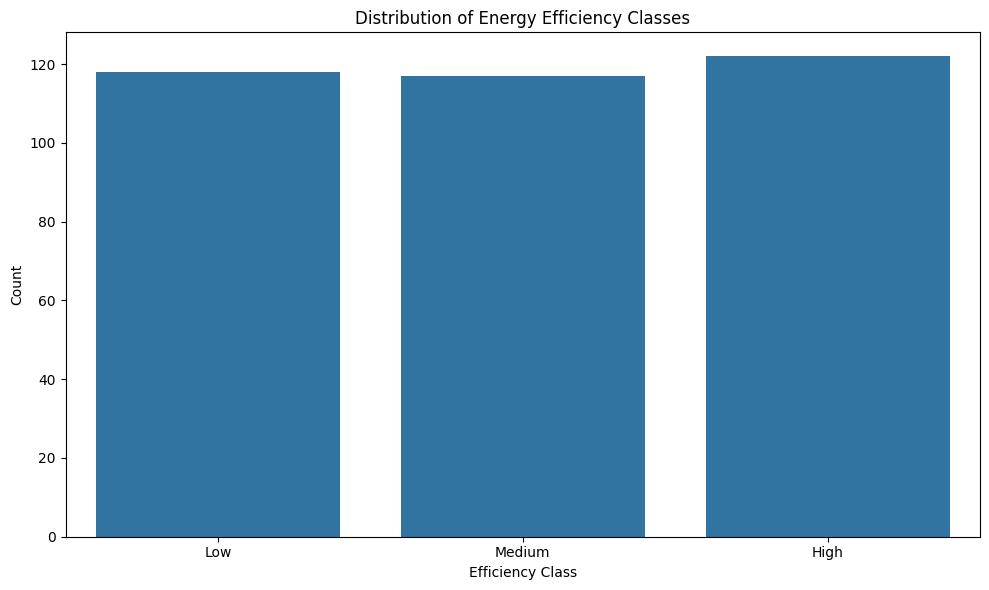


Checking for problematic values in the data:
Infinity values found: 9
NaN values found: 0

Found 2 highly correlated features (>0.9):
['proportion of global land area', 'Exchange_Adjusted_GDP_Growth']
Removed highly correlated features to prevent multicollinearity
After cleaning - Infinity: 0, NaN: 0

Top 10 features for energy efficiency classification:
                              Feature       Score
21                    CO2_growth_rate  390.646781
14                     CO2_per_capita  172.608987
10                     gdp_per_capita  110.276539
16                     GDP_per_energy  104.285990
18          Real_Purchasing_Power_GDP  103.668708
25                      high_emission  101.569503
17                       CO2_per_area   94.593112
5   Access to clean fuels for cooking   44.369246
9                          gdp_growth   34.014375
0                 CO2 emission (Tons)   33.481032


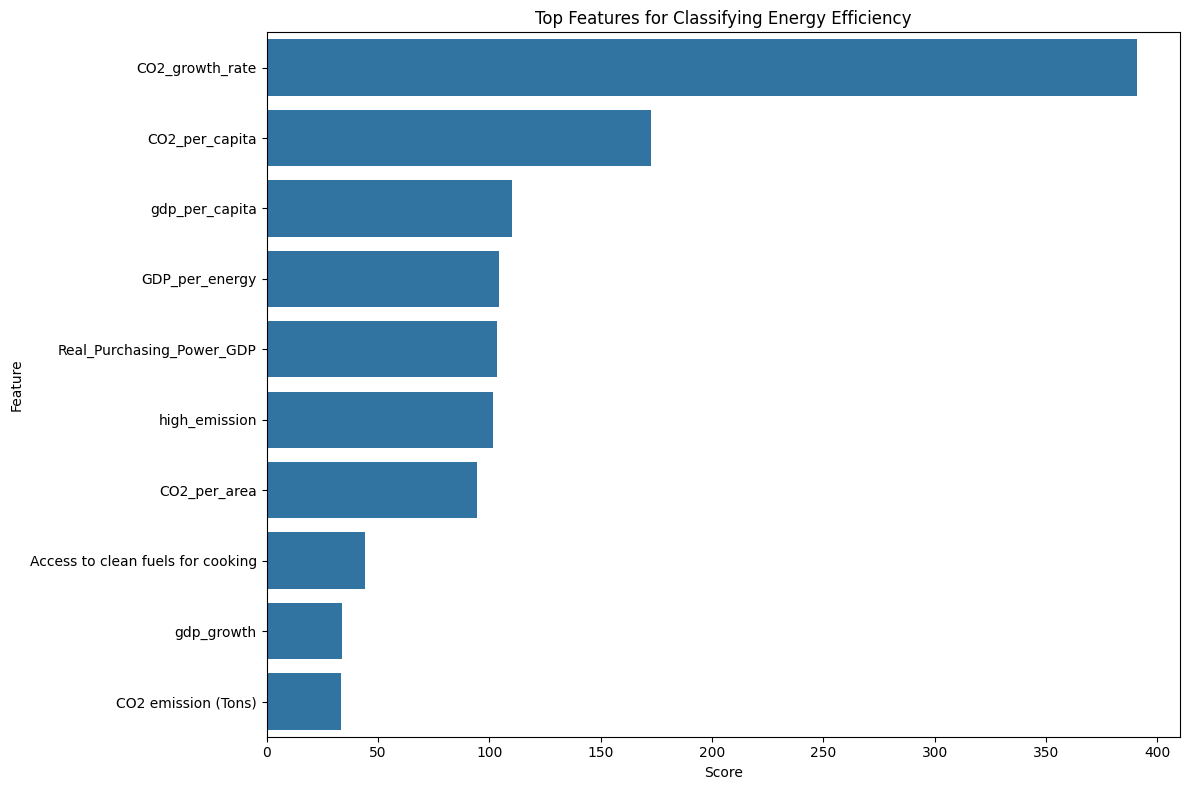


Training Decision Tree Classifier with cross-validation...
Cross-validation F1 scores: [0.79084249 0.81058201 0.92554657 0.88617869 0.88644197]
Mean CV F1 score: 0.8599 (±0.0508)
Test Accuracy: 0.9333
Test Precision: 0.9343
Test Recall: 0.9333
Test F1 Score: 0.9327


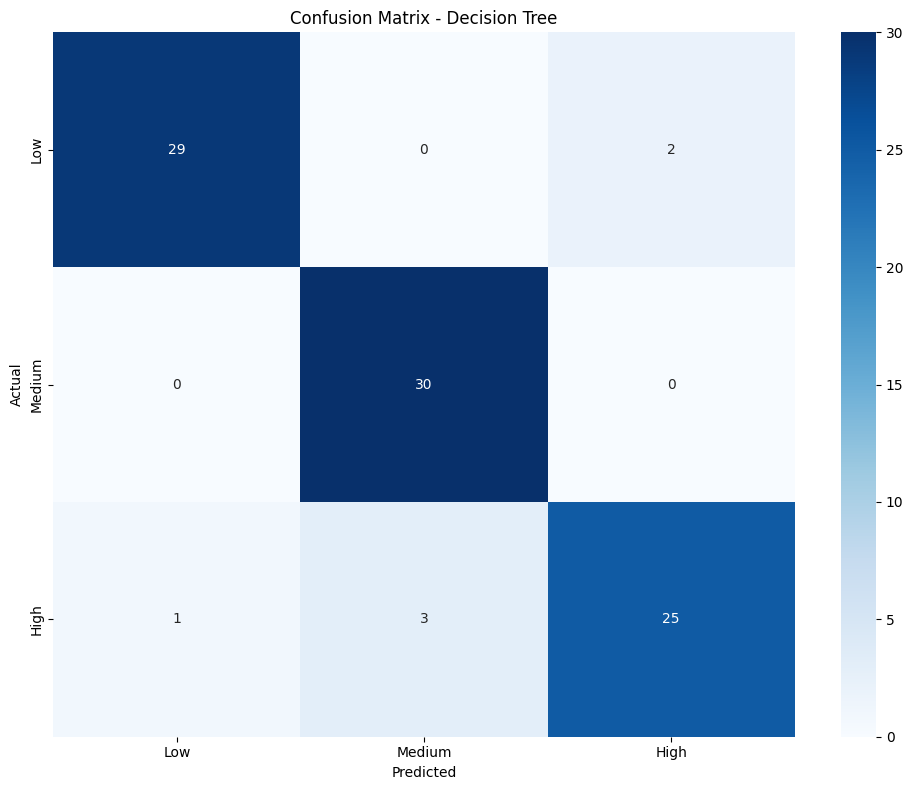


Classification Report:
              precision    recall  f1-score   support

        High       0.97      0.94      0.95        31
         Low       0.91      1.00      0.95        30
      Medium       0.93      0.86      0.89        29

    accuracy                           0.93        90
   macro avg       0.93      0.93      0.93        90
weighted avg       0.93      0.93      0.93        90


Performing hyperparameter tuning for Decision Tree...
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 5}
Best cross-validation F1 Score: 0.8799
Training F1 Score: 0.9358
Training-CV gap: 0.0559

Test set performance with tuned Decision Tree:
Accuracy: 0.9000
Precision: 0.9008
Recall: 0.9000
F1 Score: 0.8999


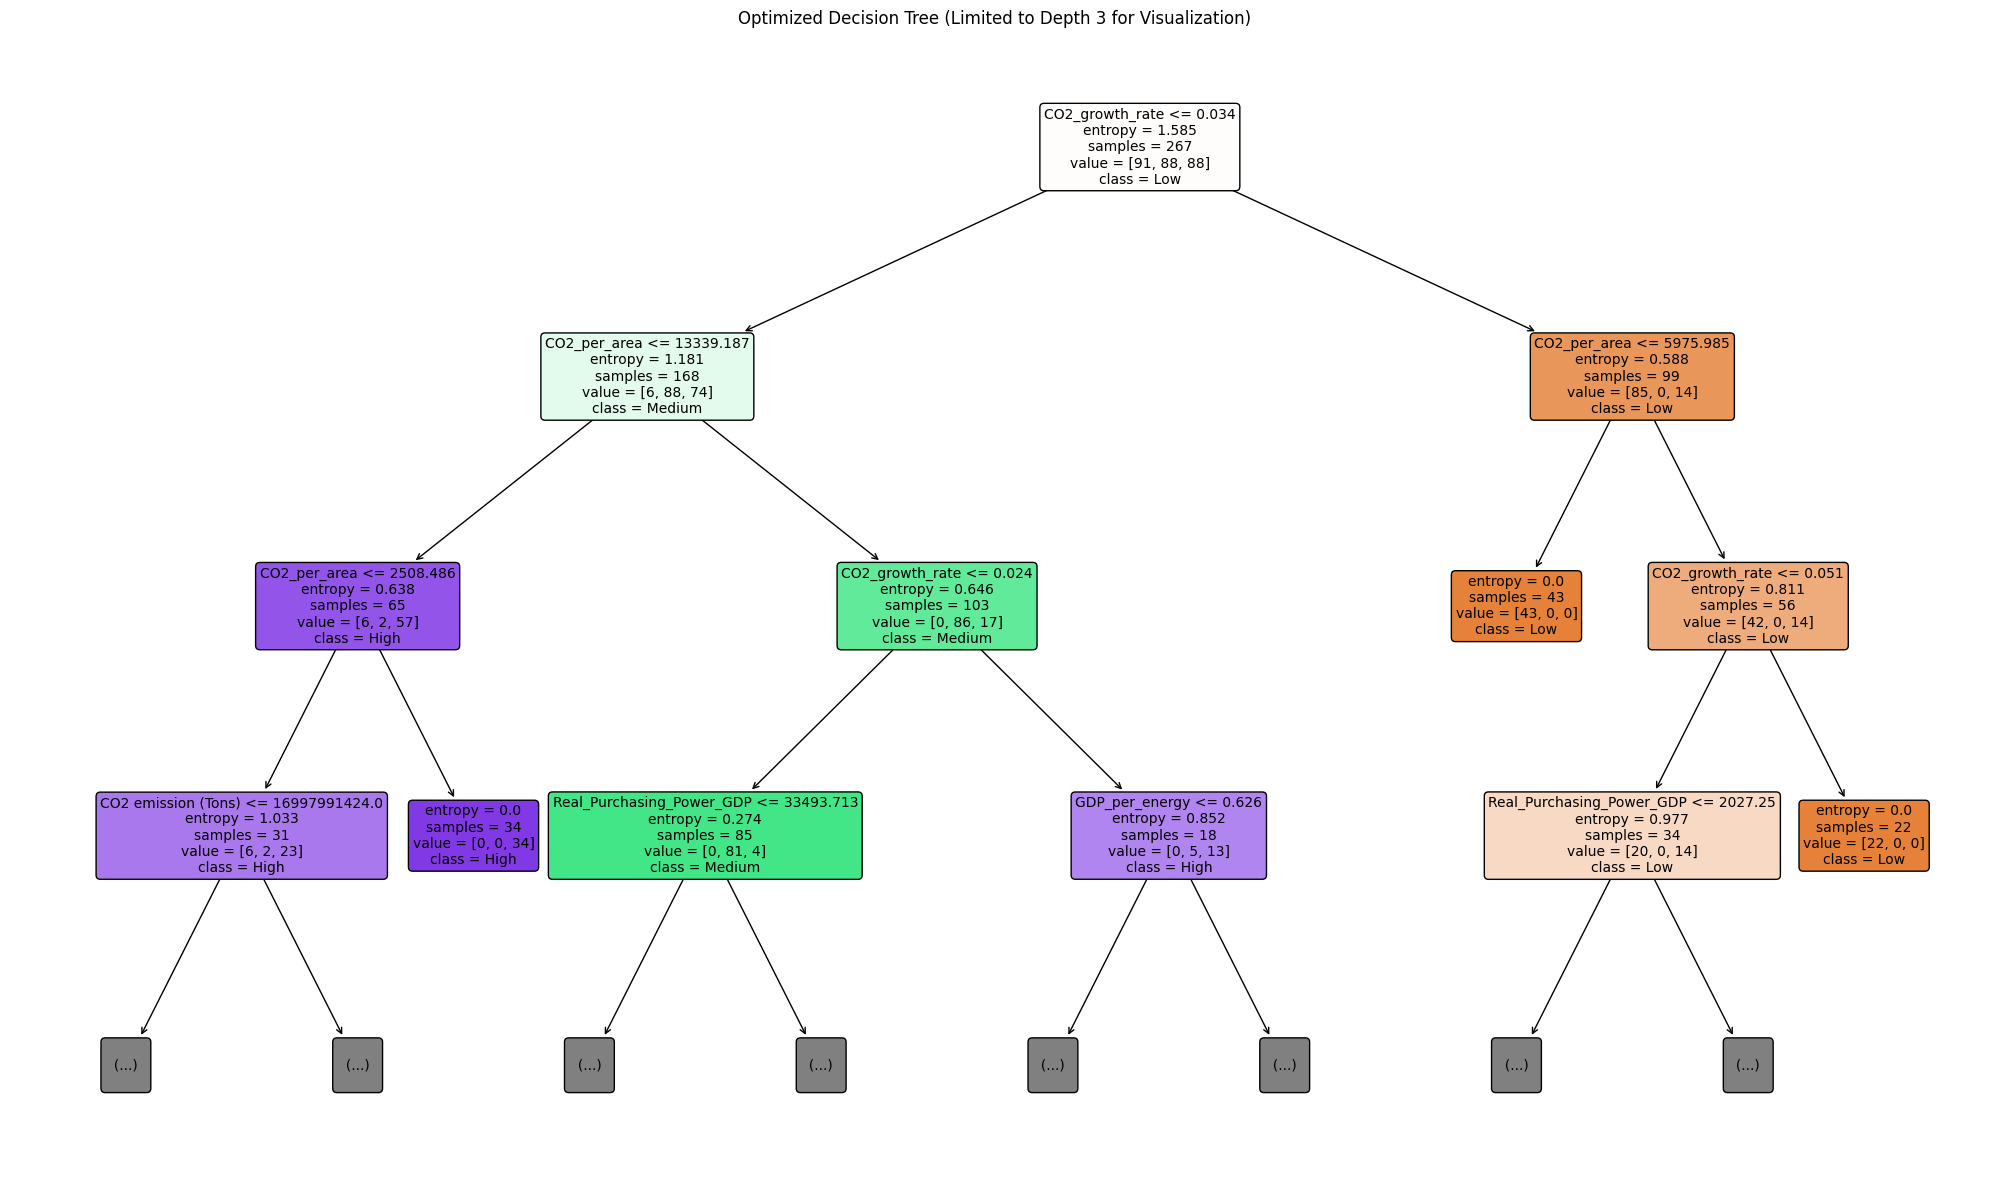

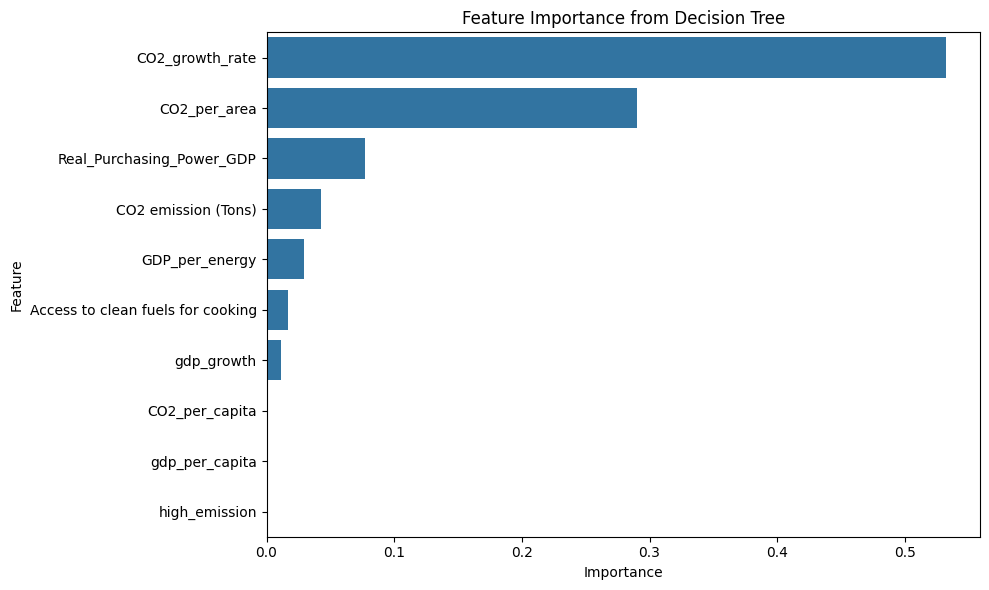


Feature Importance from Decision Tree:
                             Feature  Importance
0                    CO2_growth_rate    0.532271
6                       CO2_per_area    0.290212
4          Real_Purchasing_Power_GDP    0.077175
9                CO2 emission (Tons)    0.042415
3                     GDP_per_energy    0.029480
7  Access to clean fuels for cooking    0.016740
8                         gdp_growth    0.011708
1                     CO2_per_capita    0.000000
2                     gdp_per_capita    0.000000
5                      high_emission    0.000000


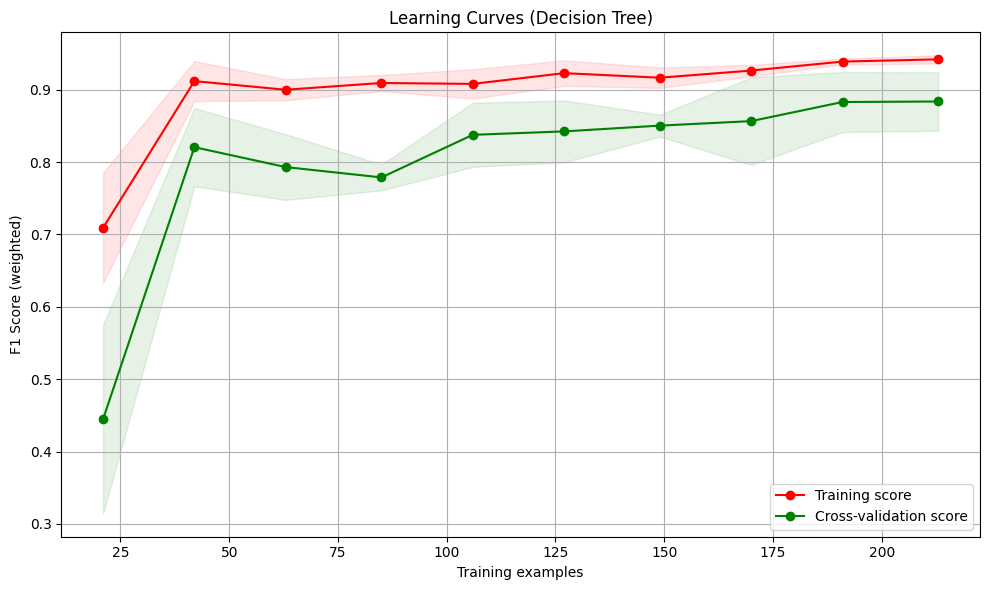


Training Random Forest for comparison...
RF Cross-validation F1 scores: [0.88696402 0.83157895 0.85195144 0.98114665 0.90380476]
RF Mean CV F1 score: 0.8911 (±0.0517)
Random Forest - Test Metrics:
Accuracy: 0.8889
Precision: 0.8924
Recall: 0.8889
F1 Score: 0.8900


<Figure size 1200x800 with 0 Axes>

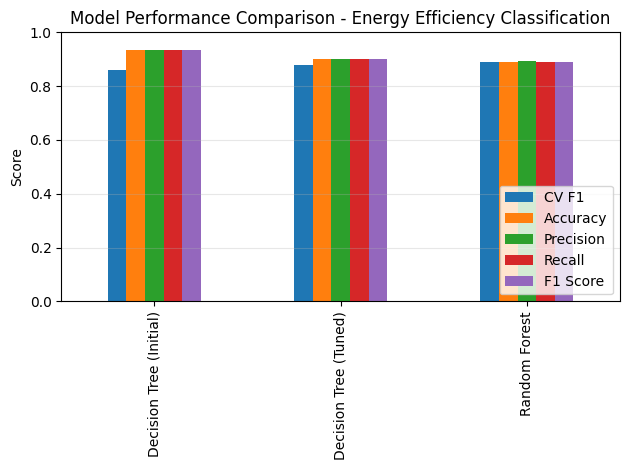


Analyzing relationship between energy efficiency and economic performance...


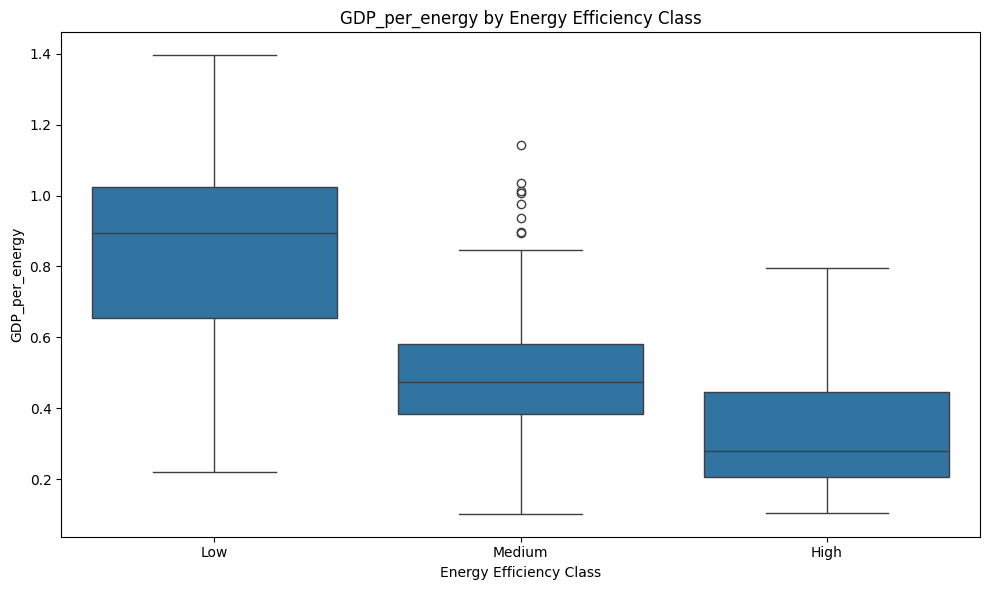


Average GDP_per_energy by efficiency class:
Low: 0.8338
Medium: 0.4977
High: 0.3311


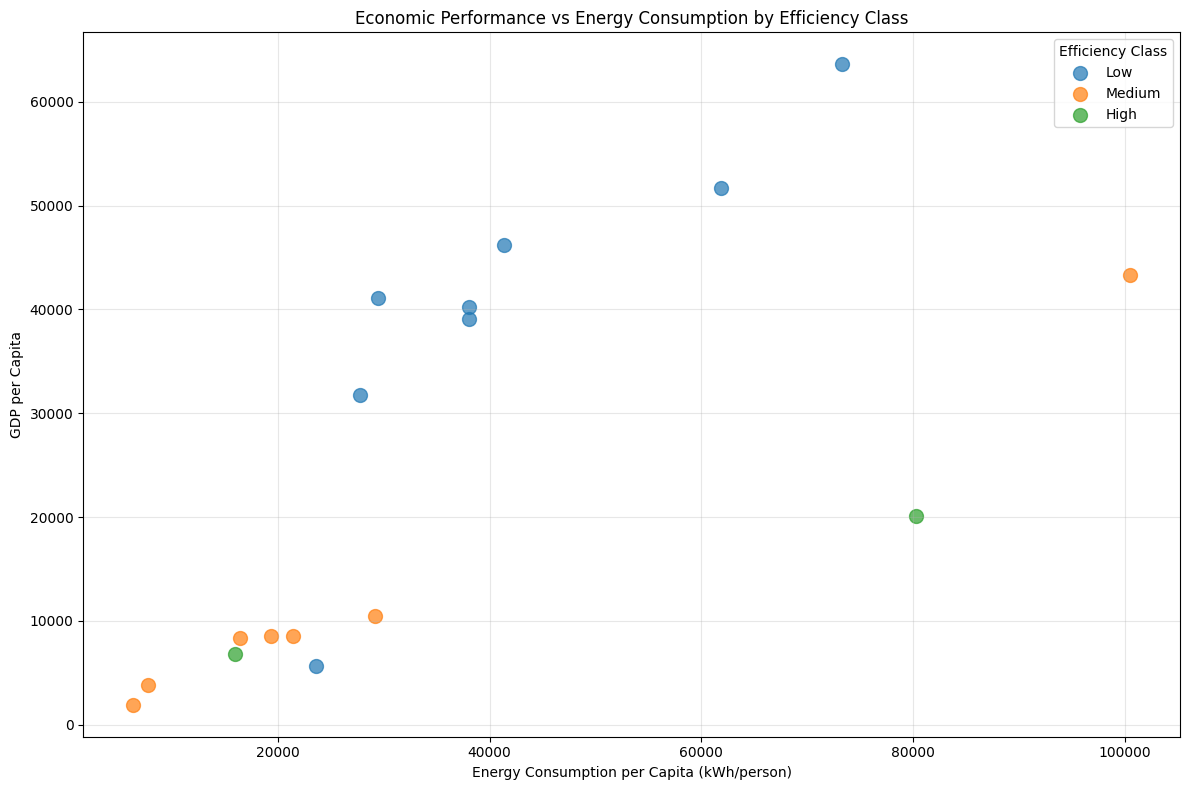


# Save model
joblib.dump(best_dt, 'best_energy_efficiency_classifier.pkl')

Energy efficiency classification model and analysis completed.


In [12]:
# ==================================================
# Building Energy Efficiency Classification Model
# ==================================================

print("=" * 50)
print("Building Energy Efficiency Classification Model")
print("=" * 50)

# Check for duplicate rows which could contribute to overfitting
duplicates = new_df.duplicated().sum()
print(f"Duplicate rows in dataset: {duplicates}")
if duplicates > 0:
    new_df = new_df.drop_duplicates()
    print("Removed duplicate rows")

# 1. Create target variable with three categories (High/Medium/Low Efficiency)
# Using Energy_per_CO2 (higher values mean more energy per unit of CO2, which is better)
q33 = new_df['Energy_per_CO2'].quantile(0.33)
q66 = new_df['Energy_per_CO2'].quantile(0.66)

# Create categories
conditions = [
    (new_df['Energy_per_CO2'] <= q33),
    (new_df['Energy_per_CO2'] > q33) & (new_df['Energy_per_CO2'] <= q66),
    (new_df['Energy_per_CO2'] > q66)
]
choices = ['Low', 'Medium', 'High']
new_df['efficiency_class'] = np.select(conditions, choices, default='Medium')

# Check class distribution
class_counts = new_df['efficiency_class'].value_counts()
print("\nEnergy Efficiency Class distribution:")
for cls in choices:
    print(f"{cls} efficiency: {class_counts[cls]} ({class_counts[cls]/len(new_df)*100:.1f}%)")

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='efficiency_class', data=new_df, order=choices)
plt.title('Distribution of Energy Efficiency Classes')
plt.xlabel('Efficiency Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 2. Define features and target
target_column = 'efficiency_class'

# Drop irrelevant columns and energy efficiency related features to avoid data leakage
exclude_columns = ['Country', 'Year', 'efficiency_class', 'Energy_per_CO2',
                  'energy_efficiency', 'Low-carbon electricity (% electricity)',
                  'Renewables (% equivalent primary energy)', 'Renewable_ratio']

features = [col for col in new_df.columns if col not in exclude_columns]

# Check for problematic values in features
print("\nChecking for problematic values in the data:")
inf_count = np.sum(np.isinf(new_df[features].values))
nan_count = np.sum(np.isnan(new_df[features].values))
print(f"Infinity values found: {inf_count}")
print(f"NaN values found: {nan_count}")

# Create feature and target variables with proper data cleaning
X = new_df[features].copy()
y = new_df[target_column].copy()

# Replace infinity values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Handle NaN values with imputation
imputer = SimpleImputer(strategy='median')  # Median is more robust to outliers
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Check for highly correlated features
corr_matrix = X_imputed.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.9)]

if high_corr_features:
    print(f"\nFound {len(high_corr_features)} highly correlated features (>0.9):")
    print(high_corr_features)
    # Remove one of each pair of highly correlated features
    X_imputed = X_imputed.drop(columns=high_corr_features)
    print(f"Removed highly correlated features to prevent multicollinearity")
    features = X_imputed.columns.tolist()

# Final check for problematic values
final_inf_count = np.sum(np.isinf(X_imputed.values))
final_nan_count = np.sum(np.isnan(X_imputed.values))
print(f"After cleaning - Infinity: {final_inf_count}, NaN: {final_nan_count}")

# 3. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.25, random_state=42, stratify=y)

# 4. Feature Selection
# Scale the data - creating and fitting one scaler for both train and test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Select top features using f_classif
k = min(10, len(features))  # Ensure k is not larger than available features
selector = SelectKBest(f_classif, k=k)
selector.fit(X_train_scaled, y_train)

# Get selected feature names
feature_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'Score': selector.scores_
}).sort_values('Score', ascending=False)

selected_features = feature_scores.head(k)['Feature'].tolist()

print(f"\nTop {k} features for energy efficiency classification:")
print(feature_scores.head(k))

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=feature_scores.head(k))
plt.title('Top Features for Classifying Energy Efficiency')
plt.tight_layout()
plt.show()

# Create selected feature datasets
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# 5. Train Decision Tree Model with Cross-Validation
print("\nTraining Decision Tree Classifier with cross-validation...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

dt = DecisionTreeClassifier(
    max_depth=6,           # Limit tree depth to prevent overfitting
    min_samples_split=5,   # Require more samples for a split
    min_samples_leaf=4,    # Require more samples in a leaf
    random_state=42
)

# Cross-validation
cv_scores = cross_val_score(dt, X_train_selected, y_train, cv=cv, scoring='f1_weighted')
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV F1 score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Train the model
dt.fit(X_train_selected, y_train)

# Make predictions
y_pred = dt.predict(X_test_selected)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Check for potential overfitting
if f1 > cv_scores.mean() + 2 * cv_scores.std():
    print("WARNING: Model may be overfitting (test F1 significantly higher than CV F1)")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=choices, yticklabels=choices)
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Classification Report
report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)

# 6. Hyperparameter Tuning for Decision Tree with Anti-Overfitting Focus
print("\nPerforming hyperparameter tuning for Decision Tree...")

# Define parameter grid focused on preventing overfitting
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6, 8],       # Limited depth options
    'min_samples_split': [5, 10, 15],    # Require more samples to split
    'min_samples_leaf': [4, 6, 8, 10]    # Require more samples in leaves
}

# Create grid search with cross-validation
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1,
    return_train_score=True  # To check for overfitting
)

# Fit grid search
grid_search.fit(X_train_selected, y_train)

# Get best parameters and performance
print("Best parameters:", grid_search.best_params_)
best_score = grid_search.best_score_
print(f"Best cross-validation F1 Score: {best_score:.4f}")

# Get training score for best model to check for overfitting
best_idx = grid_search.best_index_
train_score = grid_search.cv_results_['mean_train_score'][best_idx]
print(f"Training F1 Score: {train_score:.4f}")
print(f"Training-CV gap: {train_score - best_score:.4f}")

if train_score - best_score > 0.1:
    print("WARNING: Model still shows signs of overfitting (large gap between training and CV scores)")

# Evaluate best model on test set
best_dt = grid_search.best_estimator_
y_pred_best = best_dt.predict(X_test_selected)

accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best, average='weighted')
recall_best = recall_score(y_test, y_pred_best, average='weighted')
f1_best = f1_score(y_test, y_pred_best, average='weighted')

print(f"\nTest set performance with tuned Decision Tree:")
print(f"Accuracy: {accuracy_best:.4f}")
print(f"Precision: {precision_best:.4f}")
print(f"Recall: {recall_best:.4f}")
print(f"F1 Score: {f1_best:.4f}")

# Check if test performance is suspiciously better than CV
if f1_best > best_score + 0.05:
    print("WARNING: Tuned model may still be overfitting (test score significantly higher than CV score)")

# 7. Visualize the Decision Tree (limited to prevent overcrowded visualization)
plt.figure(figsize=(20, 12))
plot_tree(best_dt, filled=True, feature_names=selected_features, 
          class_names=choices, rounded=True, fontsize=10, max_depth=3)
plt.title('Optimized Decision Tree (Limited to Depth 3 for Visualization)')
plt.tight_layout()
plt.show()

# 8. Feature Importance from Decision Tree
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': best_dt.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance from Decision Tree')
plt.tight_layout()
plt.show()

print("\nFeature Importance from Decision Tree:")
print(feature_importance)

# 9. Learning curves to visualize overfitting
from sklearn.model_selection import learning_curve

# Compute learning curve for decision tree
train_sizes, train_scores, test_scores = learning_curve(
    best_dt, X_train_selected, y_train,
    cv=5, scoring='f1_weighted', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and std for the training scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and std for the test scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.grid()
plt.fill_between(train_sizes, train_mean - train_std,
                 train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std,
                 test_mean + test_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.title("Learning Curves (Decision Tree)")
plt.xlabel("Training examples")
plt.ylabel("F1 Score (weighted)")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# 10. Compare with Random Forest for reference (with less overfitting)
print("\nTraining Random Forest for comparison...")
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,            # Limit depth to prevent overfitting
    min_samples_split=5,    # Require more samples to split
    min_samples_leaf=4,     # Require more samples in leaves
    max_features='sqrt',    # Use sqrt of features for each split
    random_state=42
)

# Cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf, X_train_selected, y_train, cv=cv, scoring='f1_weighted')
print(f"RF Cross-validation F1 scores: {cv_scores_rf}")
print(f"RF Mean CV F1 score: {cv_scores_rf.mean():.4f} (±{cv_scores_rf.std():.4f})")

# Train the model
rf.fit(X_train_selected, y_train)
y_pred_rf = rf.predict(X_test_selected)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print(f"Random Forest - Test Metrics:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}") 
print(f"F1 Score: {f1_rf:.4f}")

# Check for potential overfitting
if f1_rf > cv_scores_rf.mean() + 2 * cv_scores_rf.std():
    print("WARNING: Random Forest may be overfitting (test F1 significantly higher than CV F1)")

# 11. Compare model performance
models = {
    'Decision Tree (Initial)': {
        'CV F1': cv_scores.mean(),
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    },
    'Decision Tree (Tuned)': {
        'CV F1': best_score,
        'Accuracy': accuracy_best,
        'Precision': precision_best,
        'Recall': recall_best,
        'F1 Score': f1_best
    },
    'Random Forest': {
        'CV F1': cv_scores_rf.mean(),
        'Accuracy': accuracy_rf,
        'Precision': precision_rf,
        'Recall': recall_rf,
        'F1 Score': f1_rf
    }
}

metrics_df = pd.DataFrame(models).T

# Plot performance comparison
plt.figure(figsize=(12, 8))
metrics_df.plot(kind='bar')
plt.title('Model Performance Comparison - Energy Efficiency Classification')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 12. Analyze relationship between efficiency class and economic indicators
print("\nAnalyzing relationship between energy efficiency and economic performance...")

# Select a key economic indicator
economic_indicator = 'GDP_per_energy'
if economic_indicator in new_df.columns:
    # Box plot of economic indicator by efficiency class
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='efficiency_class', y=economic_indicator, data=new_df, order=choices)
    plt.title(f'{economic_indicator} by Energy Efficiency Class')
    plt.xlabel('Energy Efficiency Class')
    plt.ylabel(economic_indicator)
    plt.tight_layout()
    plt.show()
    
    # Calculate mean values by class
    economic_by_class = new_df.groupby('efficiency_class')[economic_indicator].mean().reindex(choices)
    print(f"\nAverage {economic_indicator} by efficiency class:")
    for cls in choices:
        print(f"{cls}: {economic_by_class[cls]:.4f}")

# 13. Create a simple dashboard visualization (data for it)
# Prepare country level data for visualization
country_efficiency = new_df.groupby('Country')['efficiency_class'].last().reset_index()
country_gdp = new_df.groupby('Country')['gdp_per_capita'].last().reset_index()
country_energy = new_df.groupby('Country')['Primary energy consumption per capita (kWh/person)'].last().reset_index()

# Merge the data
country_data = country_efficiency.merge(country_gdp, on='Country')
country_data = country_data.merge(country_energy, on='Country')

# Create a scatter plot of GDP vs Energy by efficiency class
plt.figure(figsize=(12, 8))
for cls in choices:
    cls_data = country_data[country_data['efficiency_class'] == cls]
    plt.scatter(
        x=cls_data['Primary energy consumption per capita (kWh/person)'],
        y=cls_data['gdp_per_capita'],
        label=cls,
        alpha=0.7,
        s=100
    )

plt.title('Economic Performance vs Energy Consumption by Efficiency Class')
plt.xlabel('Energy Consumption per Capita (kWh/person)')
plt.ylabel('GDP per Capita')
plt.legend(title='Efficiency Class')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Save the best model
import joblib
joblib.dump(best_dt, 'best_energy_efficiency_classifier.pkl')
print("\n# Save model")
print("joblib.dump(best_dt, 'best_energy_efficiency_classifier.pkl')")

print("\nEnergy efficiency classification model and analysis completed.")